# **PollenNER** — извлечения сущностей для анализа сообщений Пыльца Club

---




## Заказчик

[Пыльца Club](https://pollen.club/) — краудсорсинговый сервис для людей с пыльцевой аллергией. Платформа объединяет тысячи пользователей, информируя их о текущем уровне аллергенов в воздухе и рисках для здоровья. Данные о концентрации пыльцевых частиц и прогнозах доступны через веб-интерфейс и мобильное приложение, что помогает планировать активность и корректировать терапию.



## Исполнитель



[Мельник Даниил](https://github.com/DanielNRU/)



---



## Описание проекта



Цель — создать и обучить NLP-систему, способную извлекать из пользовательских сообщений ключевую информацию о:



* **Топонимах**

* **Симптомах**

* **Медицинских препаратах**

* **Аллергенах**



---



## Задачи



1. **Подготовка и разметка данных**



 * Загрузка исторических сообщений пользователей

 * Очистка и нормализация текста

 * Аннотирование сущностей в Label Studio

 * Формирование тренировочной и тестовой выборок



2. **Разработка NER-модуля**



 * Использование предобученной модели **DeepPavlov/rubert-base-cased**

 * Активное обучение для оптимального расширения аннотаций

 * Оценка неопределённости для отбора самых информативных примеров

 * PEFT и LoRA для экономии ресурсов при тонкой настройке



3. **Построение RE-модуля**



 * Модель для классификации отношений между сущностями

 * Балансировка классов, оптимизация метрик качества

 * Интеграция в единый пайплайн с NER-модулем



4. **Тестирование и внедрение**



 * Валидация на тестовой выборке

 * Анализ ошибок и доработка сложных кейсов



---



## Технологический стек



* **Языки и библиотеки**: Python, Pandas, NumPy, scikit-learn

* **ML-фреймворки**: PyTorch, Transformers (Hugging Face), PEFT (LoRA)

* **Разметка**: Label Studio

* **Подходы**: Active Learning, Parameter-Efficient Fine-Tuning



---


## Импорты библиотек

In [4]:
# Стандартные библиотеки Python
import os
import json
import random
import re
import time
import warnings
from collections import Counter
from typing import List, Dict, Optional

# Научные вычисления и обработка данных
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import multiprocessing
from joblib import parallel_backend

# Hugging Face и трансформеры
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    Trainer,
    TrainingArguments,
    DataCollatorForTokenClassification,
    EarlyStoppingCallback,
    AutoModelForSequenceClassification,
    AutoConfig
)
from peft import LoraConfig, get_peft_model

# Внешние API и сервисы
import requests
from label_studio_sdk.client import LabelStudio
from dotenv import load_dotenv
import evaluate

## Настройка окружения и константы

In [6]:
SEED = 42
RANDOM_STATE = 42
LABEL_CONFIG = '''<View>
  <Labels name="label" toName="text">
    <Label value="TOPONYM" background="#ff0d00"/>
    <Label value="MEDICINE" background="#022bf7"/>
    <Label value="SYMPTOM" background="#ffd500"/>
    <Label value="ALLERGEN" background="#00ff55"/>
    <Label value="BODY_PART" background="#ff00ff"/>
  </Labels>

  <Relations>
    <Relation value="has_symptom" />
    <Relation value="has_medicine" />
  </Relations>

  <Text name="text" value="$text" granularity="word"/>
</View>'''

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [7]:
n_jobs = max(1, multiprocessing.cpu_count() - 1)
os.environ['LOKY_MAX_CPU_COUNT'] = str(n_jobs)

# Подавляем лишние предупреждения, чтобы не засорять вывод.
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='No label_names provided for model class')
warnings.filterwarnings('ignore', message='Could not find the number of physical cores')

# Загружаем переменные окружения из .env файла (токены, URL и т.д.)
# Для начинающих: .env файл - это файл с конфиденциальными данными (токены, пароли),
# которые не должны попадать в репозиторий кода
load_dotenv()
LS_TOKEN = os.getenv('LS_LEGACY_TOKEN')  # Токен для Label Studio
LS_URL = os.getenv('LS_URL', 'http://localhost:8080')  # URL сервера Label Studio
HF_TOKEN = os.getenv('HUGGINGFACE_HUB_TOKEN')  # Токен для HuggingFace Hub
assert LS_TOKEN and HF_TOKEN, 'Установите LS_LEGACY_TOKEN и HUGGINGFACE_HUB_TOKEN в .env'

# Инициализация клиента для работы с Label Studio через API
ls = LabelStudio(base_url=LS_URL, api_key=LS_TOKEN)

In [8]:
## Конфигурация меток и токенизатора
# Список всех сущностей, которые мы хотим распознавать.
LABELS = ['TOPONYM', 'MEDICINE', 'SYMPTOM', 'ALLERGEN', 'BODY_PART']
# Словари для преобразования между строковыми и числовыми метками.
LABEL2ID = {'O': 0, **{f'B-{l}': i*2+1 for i, l in enumerate(LABELS)}, **{f'I-{l}': i*2+2 for i, l in enumerate(LABELS)}}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

TOKENIZER = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Список размеров обучающих выборок для активного обучения.
sizes = list(range(50, 2001, 50))

# Список допустимых отношений между сущностями для задачи RE.
RE_RELATION_LABELS = ['has_symptom', 'has_medicine']

# Тестовый пример
TEST_EXAMPLES = [
    "В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.",
]

# Определяем функцию для вычисления метрик
metric = evaluate.load('seqeval')

## Вспомогательные функции

In [10]:
def bulk_import_via_http(project_id: int,
                         tasks_list: List[Dict],
                         ls_url: str,
                         ls_token: str,
                         chunk_size: int = 100,
                         max_retries: int = 3):
    """
    Импорт списка задач в Label Studio через HTTP-эндпоинт /import.

    Параметры:
    - project_id: ID проекта в Label Studio
    - tasks_list: список задач для импорта
    - ls_url: URL сервера Label Studio
    - ls_token: токен доступа
    - chunk_size: размер чанка для импорта
    - max_retries: максимальное количество попыток при ошибке

    Процесс:
    1. Разбивает список задач на чанки
    2. Отправляет каждый чанк через API
    3. При ошибке делает повторные попытки с экспоненциальной задержкой
    """
    url = f"{ls_url}/api/projects/{project_id}/import"
    headers = {'Authorization': f'Token {ls_token}', 'Content-Type': 'application/json'}
    total = len(tasks_list)

    # Проходим по списку чанков
    for i in range(0, total, chunk_size):
        chunk = tasks_list[i:i + chunk_size]
        start, end = i + 1, min(i + chunk_size, total)

        # Пытаемся отправить с ретрай
        for attempt in range(1, max_retries + 1):
            resp = requests.post(url, headers=headers, json=chunk)
            if resp.ok:
                print(f"Импортировано задач {start}–{end} из {total}")
                break
            print(f"Ошибка импорта {start}–{end}: {resp.status_code}. Попытка {attempt}/{max_retries}")
            if attempt < max_retries:
                time.sleep(2 ** attempt)  # Экспоненциальная задержка
            else:
                print(f"Не удалось импортировать {start}–{end} после {max_retries} попыток.")

def calculate_uncertainty_scores(model, texts, tokenizer, batch_size=8):
    """
    Рассчитывает оценки неопределенности для каждого текста на основе энтропии предсказаний модели.

    Параметры:
    - model: модель для предсказаний
    - texts: список текстов для оценки
    - tokenizer: токенизатор для обработки текстов
    - batch_size: размер батча для обработки

    Возвращает:
    - список оценок неопределенности для каждого текста
    """
    uncertainties = []
    model.eval()
    device = next(model.parameters()).device

    # Обработка текстов батчами
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts,
                           padding=True,
                           truncation=True,
                           max_length=512,
                           return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits
            # Вычисляем вероятности через softmax
            probs = torch.softmax(logits, dim=-1)
            # Рассчитываем энтропию как меру неопределенности
            entropy = -torch.sum(probs * torch.log(probs + 1e-10), dim=-1)
            # Усредняем энтропию по всем токенам в тексте
            avg_entropy = entropy.mean(dim=1)
            uncertainties.extend(avg_entropy.cpu().numpy())

        # Очищаем память GPU
        del outputs, logits, probs, entropy, avg_entropy
        torch.cuda.empty_cache()

    return uncertainties

def retry_on_error(func, max_retries=5, delay=2):
    """
    Декоратор для повторных попыток выполнения функции при ошибках.

    Параметры:
    - func: функция для выполнения
    - max_retries: максимальное количество попыток
    - delay: начальная задержка между попытками

    Возвращает:
    - результат выполнения функции или None при неудаче
    """
    def wrapper(*args, **kwargs):
        for attempt in range(max_retries):
            try:
                return func(*args, **kwargs)
            except Exception as e:
                if attempt == max_retries - 1:
                    raise e
                print(f"Ошибка при выполнении {func.__name__}: {str(e)}. Попытка {attempt + 1}/{max_retries}")
                time.sleep(delay * (2 ** attempt))  # Экспоненциальная задержка
        return None
    return wrapper

@retry_on_error
def create_task(ls_client, project_id, text, text_id):
    """
    Создание задачи в Label Studio с повторными попытками.
    """
    return ls_client.tasks.create(
        project=project_id,
        data={
            'text': text,
            'meta': {
                'id': str(text_id)
            }
        }
    )

@retry_on_error
def delete_task(ls_client, task_id):
    """
    Удаление задачи в Label Studio с повторными попытками.
    """
    return ls_client.tasks.delete(task_id)

@retry_on_error
def get_project_tasks(ls_client, project_id):
    """
    Получение списка задач проекта с повторными попытками.
    """
    return list(ls_client.tasks.list(project=project_id, fields=['data', 'is_labeled']))

@retry_on_error
def export_project(ls_client, project_id):
    """
    Экспорт проекта с повторными попытками.
    """
    resp = requests.get(
        f"{LS_URL}/api/projects/{project_id}/export?exportType=JSON&download_all_tasks=true",
        headers={'Authorization': f'Token {LS_TOKEN}'}
    )
    resp.raise_for_status()
    return resp.json()

@retry_on_error
def get_or_create_project(ls_client, title, label_config):
    """
    Получение существующего проекта или создание нового с повторными попытками.
    """
    try:
        proj = next((p for p in ls_client.projects.list() if p.title == title), None)
        if not proj:
            proj = ls_client.projects.create(title=title, label_config=label_config)
            print(f"Создан проект '{title}' (ID={proj.id})")
        return proj
    except Exception as e:
        print(f"Ошибка при работе с проектом '{title}': {str(e)}")
        raise

def ensure_project(texts_with_ids, title, export_path, import_prev_json=None):
    """
    Убеждаемся, что в Label Studio есть проект с нужными текстами.

    Параметры:
    - texts_with_ids: список кортежей (id, text)
    - title: название проекта
    - export_path: путь для сохранения экспортированных данных
    - import_prev_json: путь к файлу с предыдущими аннотациями

    Процесс:
    1. Проверяет существование проекта
    2. Создает новый или использует существующий
    3. Импортирует тексты и аннотации
    4. Экспортирует размеченные данные

    Возвращает:
    - список примеров с аннотациями
    """
    # Находим или создаём проект
    proj = get_or_create_project(ls, title, LABEL_CONFIG)

    # Получаем таски с повторными попытками
    tasks = get_project_tasks(ls, proj.id)

    # Если число совпадает
    if len(tasks) == len(texts_with_ids):
        labeled = sum(t.is_labeled for t in tasks)
        if labeled == len(texts_with_ids):
            print(f"Все {len(texts_with_ids)} задач размечены в '{title}', экспорт")
            data = export_project(ls, proj.id)
            with open(export_path, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)
            examples = []
            # Парсим аннотации в нужный формат
            for item in data:
                tags = []
                for ann in item.get('annotations', []):
                    for r in ann.get('result', []):
                        v = r.get('value')
                        if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                            tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
                examples.append({'text': item['data']['text'], 'tags': tags})
            print(f"Экспортировано {len(examples)} примеров в {export_path}")
            return examples
        # Если есть неразмеченные — ждём
        print(f"В '{title}' размечено {labeled}/{len(texts_with_ids)}. Заверши разметку.")
        input("Нажми Enter после разметки...")
        return ensure_project(texts_with_ids, title, export_path, import_prev_json)

    # Иначе — удаляем и создаём заново
    if tasks:
        for t in tasks:
            delete_task(ls, t.id)
        print(f"Очистили {len(tasks)} задач в '{title}'")

    existing = []
    # Импорт предыдущих аннотаций, если есть
    if import_prev_json and os.path.exists(import_prev_json):
        prev = json.load(open(import_prev_json, 'r', encoding='utf-8'))
        bulk_import_via_http(proj.id, prev, LS_URL, LS_TOKEN, chunk_size=100)
        existing = [i['data']['text'] for i in prev]

    # Создаём новые таски для оставшихся текстов
    for text_id, text in texts_with_ids:
        if text not in existing:
            create_task(ls, proj.id, text, text_id)

    print(f"Созданы {len(texts_with_ids) - len(existing)} новых задач в '{title}'")
    input(f"Разметь их и нажми Enter...")

    # Экспорт и разбираем аннотации
    data = export_project(ls, proj.id)
    with open(export_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=2)

    examples = []
    for item in data:
        tags = []
        for ann in item.get('annotations', []):
            for r in ann.get('result', []):
                v = r.get('value')
                if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                    tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
        examples.append({'text': item['data']['text'], 'tags': tags})

    print(f"Экспортировано {len(examples)} примеров в {export_path}")
    return examples

def align_labels(example):
    """
    Привязывает аннотации к токенам текста.

    Параметры:
    - example: пример с текстом и аннотациями

    Возвращает:
    - список ID меток для каждого токена
    """
    tok = TOKENIZER(example['text'], return_offsets_mapping=True, truncation=True, max_length=512)
    labels = ['O'] * len(tok['offset_mapping'])

    # Для каждой аннотации находим соответствующие токены
    for tag in example.get('tags', []):
        for i, (s, e) in enumerate(tok['offset_mapping']):
            if s >= tag['start'] and e <= tag['end']:
                # B- для начала сущности, I- для продолжения
                labels[i] = ('B-' if s == tag['start'] else 'I-') + tag['label']

    return [LABEL2ID[l] for l in labels]

def to_hf_dataset(examples):
    """
    Преобразует примеры в формат HuggingFace Dataset.

    Параметры:
    - examples: список примеров с текстами и аннотациями

    Возвращает:
    - датасет в формате HuggingFace
    - коллатор для батчей
    - список текстов
    """
    if not examples: return None, None, []

    # Преобразуем в DataFrame
    df = pd.DataFrame(examples)
    ds = Dataset.from_pandas(df)

    # Сохраняем тексты для последующего анализа
    texts = df['text'].tolist()

    def fn(ex):
        # Токенизация и выравнивание меток
        tok = TOKENIZER(ex['text'], truncation=True, padding='max_length', max_length=512)
        aligned = align_labels(ex)
        tok['labels'] = aligned + [-100] * (512 - len(aligned))  # -100 для padding
        return tok

    ds = ds.map(fn, batched=False, remove_columns=['text','tags'])
    return ds, DataCollatorForTokenClassification(TOKENIZER), texts

def update_remaining_dataset(remaining_df, json_file):
    """
    Обновляет оставшийся датасет, удаляя из него сообщения, которые были размечены.
    Args:
        remaining_df: DataFrame с оставшимися сообщениями
        json_file: путь к JSON файлу с размеченными данными
    Returns:
        Обновленный DataFrame с оставшимися сообщениями
    """
    # Удаляем все print, связанные с размером датасета и совпадениями
    # Загружаем размеченные данные
    with open(json_file, 'r', encoding='utf-8') as f:
        labeled_data = json.load(f)
    # Получаем ID сообщений из JSON файла
    labeled_ids = []
    for item in labeled_data:
        if 'data' in item and 'meta' in item['data'] and 'id' in item['data']['meta']:
            labeled_ids.append(str(item['data']['meta']['id']))
    if labeled_ids:
        # Проверяем, есть ли совпадения ID
        matching_ids = remaining_df.index.astype(str).isin(labeled_ids)
        # Удаляем строки, где индекс совпадает с ID из JSON
        remaining_df = remaining_df[~remaining_df.index.astype(str).isin(labeled_ids)]
    return remaining_df

def compute_metrics(p):
    """
    Вычисляет метрики для оценки модели NER.
    """
    preds = p.predictions.argmax(-1)
    refs, hyps = [], []
    for pr, gt in zip(preds, p.label_ids):
        r_seq, h_seq = [], []
        for pi, gi in zip(pr, gt):
            if gi == -100:
                continue
            r_seq.append(ID2LABEL[gi])
            h_seq.append(ID2LABEL[pi])
        refs.append(r_seq)
        hyps.append(h_seq)
    out = metric.compute(predictions=hyps, references=refs)
    return {
        'precision': out['overall_precision'],
        'recall': out['overall_recall'],
        'f1': out['overall_f1']
    }

def predict_entities(text: str, model, tokenizer, id2label: Dict[int, str]) -> List[Dict]:
    """
    Извлекает именованные сущности из текста с помощью обученной модели.

    Args:
        text (str): Входной текст для анализа
        model: Обученная модель NER
        tokenizer: Токенизатор для обработки текста
        id2label (Dict[int, str]): Словарь для преобразования ID в метки

    Returns:
        List[Dict]: Список словарей с найденными сущностями в формате:
            [{'text': 'текст сущности', 'label': 'тип сущности', 'start': начало, 'end': конец}]
    """
    # Определяем устройство для вычислений (GPU/CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Токенизация текста с сохранением маппинга позиций
    inputs = tokenizer(
        text,
        return_tensors="pt",
        return_offsets_mapping=True,
        truncation=True,
        max_length=512
    )
    offset_mapping = inputs.pop('offset_mapping')[0]

    # Перенос входных данных на нужное устройство
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Получение предсказаний модели
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = outputs.logits.argmax(-1)[0]

    # Перенос предсказаний обратно на CPU для обработки
    predictions = predictions.cpu()

    # Обработка предсказаний и сбор сущностей
    entities = []
    current_entity = None

    # Проходим по всем токенам и их позициям
    for pred, (start, end) in zip(predictions, offset_mapping):
        # Пропускаем специальные токены (CLS, SEP, PAD)
        if start == 0 and end == 0:
            continue

        # Получаем метку для текущего токена
        label = id2label[pred.item()]

        if label.startswith('B-'):
            # Если встретили начало новой сущности
            if current_entity:
                # Сохраняем предыдущую сущность
                entities.append(current_entity)
            # Создаем новую сущность
            current_entity = {
                'text': text[start:end],
                'label': label[2:],  # Убираем префикс B-
                'start': start,
                'end': end
            }
        elif label.startswith('I-') and current_entity and label[2:] == current_entity['label']:
            # Продолжаем текущую сущность
            current_entity['text'] += text[start:end]
            current_entity['end'] = end
        else:
            # Если встретили токен вне сущности
            if current_entity:
                # Сохраняем текущую сущность
                entities.append(current_entity)
                current_entity = None

    # Добавляем последнюю сущность, если она есть
    if current_entity:
        entities.append(current_entity)

    return entities

def test_model_on_example(model, tokenizer, text):
    """
    Тестирует только NER модель на одном примере и выводит результаты разметки в унифицированном формате.
    Выводит все определенные сущности.
    """
    print(f"\nТестовый пример:")
    print(f"Текст: {text}")

    # Получаем предсказанные сущности
    entities = predict_entities(text, model, tokenizer, ID2LABEL)

    # Группируем сущности по типу
    ent_by_type = {label: [] for label in LABELS}
    for ent in entities:
        if ent['label'] in ent_by_type:
            ent_by_type[ent['label']].append(ent['text'])

    # Выводим результаты NER
    print("\n[NER] Результаты анализа:")
    for label in LABELS:
        if ent_by_type[label]:
            print(f"{label}: {', '.join(ent_by_type[label])}")
        else:
            print(f"{label}: не найдено")

In [11]:
def run_cycle(df_path: str, sizes, start_size: Optional[int] = None) -> None:
    """
    Запускает цикл обучения модели NER с активным обучением.

    Args:
        df_path (str): Путь к исходному датасету
        start_size (Optional[int]): Размер выборки, с которой начать обучение
    """
    # Загружаем датасет и создаем копию для оставшихся сообщений
    df = pd.read_csv(df_path, sep=';', index_col=0)
    print(f"Загружен исходный датасет размером {len(df)} сообщений")
    print("Первые 5 строк исходного датасета:")
    print(df.head())

    # Если указан start_size, находим его индекс в списке sizes
    start_index = 0
    if start_size is not None:
        try:
            start_index = sizes.index(start_size)
            print(f"Начинаем с итерации {start_index + 1} (размер выборки {start_size})")
        except ValueError:
            print(f"Ошибка: размер выборки {start_size} не найден в списке допустимых размеров")
            return

    # Проверяем существование тестового проекта
    test_project_title = 'PollenNER TEST'
    test_project = get_or_create_project(ls, test_project_title, LABEL_CONFIG)
    test_tasks = get_project_tasks(ls, test_project.id)

    # Если тестовый проект пустой или не существует, создаем его
    if not test_tasks:
        print("\nСоздание тестового проекта из случайных записей")
        # Выбираем 100 случайных записей с фиксированным seed
        test_df = df.sample(n=100, random_state=SEED)
        test_texts_with_ids = [(idx, text) for idx, text in zip(test_df.index, test_df['text'])]

        # Создаем задачи в Label Studio
        for text_id, text in test_texts_with_ids:
            create_task(ls, test_project.id, text, text_id)

        print(f"Создано {len(test_texts_with_ids)} тестовых задач")
        print("Пожалуйста, разместите тестовые данные в Label Studio")
        input("Нажмите Enter после завершения разметки...")

        # Экспортируем размеченные данные
        test_data = export_project(ls, test_project.id)
        with open('PollenNER_TEST.json', 'w', encoding='utf-8') as f:
            json.dump(test_data, f, ensure_ascii=False, indent=2)

        # Преобразуем данные в формат для обучения
        test_ex = []
        for item in test_data:
            tags = []
            for ann in item.get('annotations', []):
                for r in ann.get('result', []):
                    v = r.get('value')
                    if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                        tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
            test_ex.append({'text': item['data']['text'], 'tags': tags})

        # Создаем тестовый датасет
        test_ds, _, _ = to_hf_dataset(test_ex)

        # Обновляем оставшийся датасет
        test_ids = [str(item['data']['meta']['id']) for item in test_data]
        remaining_df = df[~df.index.astype(str).isin(test_ids)]
        print(f"Размер оставшегося датасета после создания тестового: {len(remaining_df)}")
    else:
        print("\nТестовый проект уже существует, загружаем данные")
        # Загружаем существующие тестовые данные
        with open('PollenNER_TEST.json', 'r', encoding='utf-8') as f:
            test_data = json.load(f)

        # Преобразуем данные в формат для обучения
        test_ex = []
        for item in test_data:
            tags = []
            for ann in item.get('annotations', []):
                for r in ann.get('result', []):
                    v = r.get('value')
                    if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                        tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
            test_ex.append({'text': item['data']['text'], 'tags': tags})

        test_ds, _, _ = to_hf_dataset(test_ex)
        test_ids = [str(item['data']['meta']['id']) for item in test_data]
        remaining_df = df[~df.index.astype(str).isin(test_ids)]
        print(f"Размер оставшегося датасета: {len(remaining_df)}")

    results = []

    # --- Инициализация базовой модели с dropout через конфиг ---
    config = AutoConfig.from_pretrained(
        'DeepPavlov/rubert-base-cased',
        hidden_dropout_prob=0.3,  # Dropout для регуляризации
        attention_probs_dropout_prob=0.3,  # Dropout на внимании
        id2label=ID2LABEL,
        label2id=LABEL2ID
    )
    base_model = AutoModelForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased', config=config)

    # Если начинаем не с начала, загружаем последнюю обученную модель
    if start_index > 0:
        prev_size = sizes[start_index - 1]
        model_path = f'models/pollen_ner_{prev_size}'
        if os.path.exists(model_path):
            print(f"Загружаем модель из {model_path}")
            model = get_peft_model(base_model,
                                   LoraConfig(task_type='TOKEN_CLS',
                                              r=16,
                                              lora_alpha=32,
                                              lora_dropout=0.1))
            model.load_adapter(model_path, adapter_name="default")
            # Перемещаем модель на GPU, если доступен
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            model = model.to(device)
            print(f"Модель перемещена на {device}")
        else:
            print(f"Ошибка: модель {model_path} не найдена")
            return
    else:
        model = get_peft_model(base_model, LoraConfig(task_type='TOKEN_CLS',
                                                      r=16,
                                                      lora_alpha=32,
                                                      lora_dropout=0.1))
        # Перемещаем модель на GPU, если доступен
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Модель перемещена на {device}")

    # Продолжаем с указанной итерации
    for i, size in enumerate(sizes[start_index:], start_index):
        if start_size and size < start_size:
            continue
        print(f"\n[NER] Начинаем итерацию с размером выборки {size}")

        # Проверяем наличие существующего проекта для текущего размера
        title = f'PollenNER TRAIN {size}'
        export_file = f'PollenNER_TRAIN_{size}.json'

        # Проверяем, существует ли проект и все ли задачи размечены
        proj = get_or_create_project(ls, title, LABEL_CONFIG)
        tasks = get_project_tasks(ls, proj.id)

        if tasks and all(t.is_labeled for t in tasks):
            print(f"Найден существующий размеченный проект для размера {size}")
            # Экспортируем размеченные данные
            data = export_project(ls, proj.id)
            with open(export_file, 'w', encoding='utf-8') as f:
                json.dump(data, f, ensure_ascii=False, indent=2)

            # Преобразуем данные в формат для обучения
            train_ex = []
            for item in data:
                tags = []
                for ann in item.get('annotations', []):
                    for r in ann.get('result', []):
                        v = r.get('value')
                        if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                            tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
                train_ex.append({'text': item['data']['text'], 'tags': tags})
        else:
            # Если это первая итерация и проект пустой, создаем его с нуля
            if i == start_index and not tasks:
                print(f"\nСоздание первого тренировочного проекта с размером {size}")
                # Выбираем случайные записи с фиксированным seed
                train_df = remaining_df.sample(n=size, random_state=SEED)
                train_texts_with_ids = [(idx, text) for idx, text in zip(train_df.index, train_df['text'])]

                # Создаем задачи в Label Studio
                for text_id, text in train_texts_with_ids:
                    create_task(ls, proj.id, text, text_id)

                print(f"Создано {len(train_texts_with_ids)} тренировочных задач")
                print("Пожалуйста, разместите тренировочные данные в Label Studio")
                input("Нажмите Enter после завершения разметки...")

                # Экспортируем размеченные данные
                data = export_project(ls, proj.id)
                with open(export_file, 'w', encoding='utf-8') as f:
                    json.dump(data, f, ensure_ascii=False, indent=2)

                # Преобразуем данные в формат для обучения
                train_ex = []
                for item in data:
                    tags = []
                    for ann in item.get('annotations', []):
                        for r in ann.get('result', []):
                            v = r.get('value')
                            if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                                tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
                    train_ex.append({'text': item['data']['text'], 'tags': tags})
            else:
                # Загружаем размеченные данные из предыдущей итерации
                prev_size = sizes[i-1] if i > 0 else 0
                prev_json = f'PollenNER_TRAIN_{prev_size}.json'
                if os.path.exists(prev_json):
                    print(f"Загружаем размеченные данные из {prev_json}")
                    with open(prev_json, 'r', encoding='utf-8') as f:
                        prev_data = json.load(f)

                    # Создаем список задач для импорта
                    tasks_list = []

                    # Добавляем размеченные данные из предыдущей итерации
                    for item in prev_data:
                        tasks_list.append({
                            'data': {
                                'text': item['data']['text'],
                                'meta': {
                                    'id': item['data']['meta']['id']
                                }
                            },
                            'annotations': item.get('annotations', [])
                        })

                    # Импортируем размеченные данные
                    if tasks_list:
                        print(f"Импортируем {len(tasks_list)} размеченных сообщений из предыдущей итерации")
                        bulk_import_via_http(proj.id, tasks_list, LS_URL, LS_TOKEN)

                # Выбираем наименее уверенные примеры из оставшегося датасета
                if len(remaining_df) > 0:
                    # Получаем оценки неопределенности для всех оставшихся сообщений
                    uncertainties = calculate_uncertainty_scores(model,
                                                                 remaining_df['text'].tolist(),
                                                                 TOKENIZER)

                    # Выбираем сообщения с наивысшей неопределенностью
                    # Количество новых примеров = текущий размер - предыдущий размер
                    n_new_samples = size - prev_size
                    selected_indices = select_samples_improved(
                        model,
                        remaining_df['text'].tolist(),
                        TOKENIZER,
                        n_samples=n_new_samples,
                        remaining_texts=remaining_df['text'].tolist(),
                        current_iteration=i
                    )

                    # Получаем выбранные сообщения с их ID
                    selected_df = remaining_df.iloc[selected_indices]
                    train_texts = [(idx, text) for idx, text in zip(selected_df.index, selected_df['text'])]

                    # Добавляем новые сообщения в проект
                    print(f"Добавляем {len(train_texts)} новых сообщений для разметки")
                    for text_id, text in train_texts:
                        create_task(ls, proj.id, text, text_id)

                    # Ждем разметки новых данных
                    print(f"\nРазметьте {len(train_texts)} новых сообщений в Label Studio")
                    input("Нажмите Enter после завершения разметки...")

                    # Экспортируем все размеченные данные
                    data = export_project(ls, proj.id)
                    with open(export_file, 'w', encoding='utf-8') as f:
                        json.dump(data, f, ensure_ascii=False, indent=2)

                    # Преобразуем данные в формат для обучения
                    train_ex = []
                    for item in data:
                        tags = []
                        for ann in item.get('annotations', []):
                            for r in ann.get('result', []):
                                v = r.get('value')
                                if v and isinstance(v, dict) and 'start' in v and 'end' in v and 'labels' in v:
                                    tags.append({'start': v['start'], 'end': v['end'], 'label': v['labels'][0]})
                        train_ex.append({'text': item['data']['text'], 'tags': tags})
                else:
                    print("Больше нет доступных сообщений для обучения")
                    break

        # Обновляем оставшийся датасет
        remaining_df = update_remaining_dataset(remaining_df, export_file)

        print(f"После итерации {i+1} осталось {len(remaining_df)} сообщений")

        train_ds, coll, train_texts = to_hf_dataset(train_ex)

        # Настройка аргументов тренировки
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        run_name = f"pollen_ner_{size}_{timestamp}"

        args = TrainingArguments(
            output_dir=f'runs/train_{size}',
            run_name=run_name,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=10,
            load_best_model_at_end=True,
            metric_for_best_model='eval_f1',
            greater_is_better=True,
            eval_strategy='epoch',
            save_strategy='epoch',
            save_total_limit=2,
            push_to_hub=True,
            hub_model_id=f'pollen-ner-{size}',
            hub_token=HF_TOKEN,
            no_cuda=not torch.cuda.is_available(),
            weight_decay=0.01  # L2-регуляризация для борьбы с переобучением
        )

        # Создаем trainer
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=test_ds,
            data_collator=coll,
            tokenizer=TOKENIZER,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(
                early_stopping_patience=2,
                early_stopping_threshold=0.001
            )]
        )

        print(f"[NER] Обучение на {size} примерах")
        trainer.train()
        ev = trainer.evaluate()
        print(f"[NER] Результаты: F1 = {ev['eval_f1']:.4f}")

        # Получаем предсказания для тестового набора
        predictions = trainer.predict(test_ds)
        preds = predictions.predictions.argmax(-1)
        labels = predictions.label_ids

        # Подготавливаем списки для эталонных и предсказанных последовательностей
        refs, hyps = [], []
        for pr, gt in zip(preds, labels):
            r_seq, h_seq = [], []
            for pi, gi in zip(pr, gt):
                if gi == -100:
                    continue
                r_seq.append(ID2LABEL[gi])
                h_seq.append(ID2LABEL[pi])
            refs.append(r_seq)
            hyps.append(h_seq)

        # Преобразуем последовательности в плоский формат для classification_report
        flat_refs = []
        flat_hyps = []
        for r_seq, h_seq in zip(refs, hyps):
            flat_refs.extend(r_seq)
            flat_hyps.extend(h_seq)

        # Выводим подробный отчет о классификации
        print("\n[NER] Подробный отчет о классификации:")
        print(classification_report(flat_refs,
                                    flat_hyps,
                                    digits=4))

        # Сохраняем лучшую модель
        model_save_path = f'models/pollen_ner_{size}'
        os.makedirs(model_save_path, exist_ok=True)
        trainer.save_model(model_save_path)
        print(f"[NER] Модель сохранена в {model_save_path}")

        # --- Сохраняем только лучшую и одну финальную модель NER ---
        best_f1 = -1
        best_model_path = 'models/pollen_ner_best'

        if ev['eval_f1'] > best_f1:
            best_f1 = ev['eval_f1']
            os.makedirs(best_model_path, exist_ok=True)
            trainer.save_model(best_model_path)
            TOKENIZER.save_pretrained(best_model_path)
            print(f"[NER] Лучшая модель за все итерации сохранена в {best_model_path}")

        # Тестируем модель на примерах после каждой итерации
        print("\n[NER] Тестирование модели после обучения:")
        test_model_on_example(model, TOKENIZER, TEST_EXAMPLES[0])

        results.append({'size': size, 'f1': ev['eval_f1']})

        # Загружаем лучшую модель для следующей итерации
        model = get_peft_model(base_model,
                               LoraConfig(task_type='TOKEN_CLS',
                                          r=16,
                                          lora_alpha=32,
                                          lora_dropout=0.1))
        model.load_adapter(model_save_path, adapter_name="default")
        # Перемещаем модель на GPU, если доступен
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Модель перемещена на {device}")

        # После каждой итерации выводим статистику распределения классов по train_texts
        from collections import Counter
        print(f"\nСтатистика распределения классов в тренировочном датасете после итерации {i+1}:")
        all_labels = []
        for ex in train_texts:
            # Для каждого текста можно получить предсказания NER, но если train_texts — это список текстов, то статистика по ним
            # Если нужно по меткам, то train_ex содержит 'tags'
            pass  # Можно доработать, если нужно по меткам
        # Если train_ex доступен, можно посчитать по меткам:
        if 'train_ex' in locals():
            for ex in train_ex:
                for tag in ex.get('tags', []):
                    all_labels.append(tag['label'])
            print(Counter(all_labels))
        else:
            print('Нет данных для подсчёта статистики по меткам.')

    # Визуализация результатов
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    results_df = pd.DataFrame(results)
    ax = plt.gca()
    sns.lineplot(data=results_df, x='size', y='f1', marker='o', ax=ax)
    ax.set_title('Зависимость F1 от размера выборки', pad=20)
    ax.set_xlabel('Размер обучающей выборки')
    ax.set_ylabel('F1 Score')
    # Подпись только у максимального значения F1
    max_idx = results_df['f1'].idxmax()
    max_x = results_df.loc[max_idx, 'size']
    max_y = results_df.loc[max_idx, 'f1']
    ax.annotate(f'{max_y:.3f}', (max_x, max_y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                color='red',
                fontsize=12,
                fontweight='bold')
    plt.tight_layout()

    # Сохраняем график на диск
    plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')

    # Выводим график на экран
    plt.show()

    # Закрываем график после сохранения и отображения
    plt.close()

    # Сохраняем финальный оставшийся датасет
    remaining_df.to_csv('remaining_dataset_final.csv', sep=';')
    print(f"\nФинальный оставшийся датасет сохранен в remaining_dataset_final.csv")
    print(f"Размер финального датасета: {len(remaining_df)} сообщений")

    # После цикла обучения NER:
    last_ner_model = model  # Сохраняем последнюю обученную NER-модель

    # Загружаем последнюю сохранённую модель из директории
    last_size = sizes[-1] if start_size is None else sizes[start_index + len(results) - 1]
    model_save_path = f'models/pollen_ner_{last_size}'
    base_model = AutoModelForTokenClassification.from_pretrained('DeepPavlov/rubert-base-cased',
                                                                 id2label=ID2LABEL,
                                                                 label2id=LABEL2ID)
    last_ner_model = get_peft_model(base_model,
                                    LoraConfig(task_type='TOKEN_CLS',
                                               r=16,
                                               lora_alpha=32,
                                               lora_dropout=0.1))
    last_ner_model.load_adapter(model_save_path,
                                adapter_name="default")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    last_ner_model = last_ner_model.to(device)
    return last_ner_model

def calculate_text_diversity(texts, n_clusters=5):
    """
    Рассчитывает разнообразие текстов с помощью кластеризации TF-IDF.

    Параметры:
    - texts: список текстов
    - n_clusters: количество кластеров для кластеризации

    Возвращает:
    - оценку разнообразия текстов (0-1)
    """
    with parallel_backend('loky', n_jobs=n_jobs):
        # Векторизация текстов
        vectorizer = TfidfVectorizer(max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(texts)

        # Кластеризация текстов
        kmeans = KMeans(
            n_clusters=min(n_clusters, len(texts)),
            random_state=42
        )
        clusters = kmeans.fit_predict(tfidf_matrix)

        # Анализ распределения текстов по кластерам
        cluster_counts = Counter(clusters)

        # Нормализация счетчиков для получения оценки разнообразия
        total = len(texts)
        diversity_scores = [1 - (count/total) for count in cluster_counts.values()]

        return np.mean(diversity_scores)

def calculate_class_distribution(texts, tokenizer, model):
    """
    Рассчитывает распределение классов в наборе текстов.

    Параметры:
    - texts: список текстов
    - tokenizer: токенизатор
    - model: модель для предсказаний

    Возвращает:
    - словарь с распределением классов
    """
    class_counts = Counter()
    total_tokens = 0

    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(next(model.parameters()).device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = outputs.logits.argmax(-1)[0]

        for pred in predictions:
            label = ID2LABEL[pred.item()]
            if label != 'O':
                class_counts[label.split('-')[1]] += 1
                total_tokens += 1

    return {k: v/total_tokens for k, v in class_counts.items()} if total_tokens > 0 else {}

def calculate_class_balance_score(class_distribution):
    """
    Рассчитывает оценку баланса классов.

    Параметры:
    - class_distribution: распределение классов

    Возвращает:
    - оценку баланса (0-1)
    """
    if not class_distribution:
        return 0

    # Расчет энтропии распределения
    probs = list(class_distribution.values())
    entropy = -sum(p * np.log(p) for p in probs)

    # Нормализация энтропии
    max_entropy = np.log(len(LABELS))
    return entropy / max_entropy if max_entropy > 0 else 0

def select_samples_improved(model,
                            texts,
                            tokenizer,
                            n_samples=50,
                            remaining_texts=None,
                            current_iteration=0):
    """
    Улучшенная стратегия отбора сообщений для активного обучения.
    Учитывает неопределенность модели, разнообразие текстов и баланс классов.

    Параметры:
    - model: текущая модель
    - texts: список текстов для отбора
    - tokenizer: токенизатор
    - n_samples: количество сообщений для отбора
    - remaining_texts: оставшиеся тексты для учета разнообразия
    - current_iteration: текущая итерация обучения

    Возвращает:
    - индексы отобранных сообщений
    """
    # Веса для метрик
    weights = {
        'uncertainty': 0.5,      # Неопределенность модели
        'text_diversity': 0.2,   # Разнообразие текстов
        'class_balance': 0.3     # Баланс классов
    }

    # Получаем оценки неопределенности
    uncertainties = calculate_uncertainty_scores(model, texts, tokenizer)

    # Рассчитываем разнообразие текстов
    n_clusters = min(5, max(2, len(texts) // 10))
    if remaining_texts:
        text_diversity = calculate_text_diversity(texts + remaining_texts, n_clusters=n_clusters)
    else:
        text_diversity = calculate_text_diversity(texts, n_clusters=n_clusters)

    # Рассчитываем текущее распределение классов
    current_distribution = calculate_class_distribution(texts, tokenizer, model)
    class_balance = calculate_class_balance_score(current_distribution)

    # Нормализация неопределенности
    uncertainties = np.array(uncertainties)
    uncertainties = (uncertainties - uncertainties.min()) / (uncertainties.max() - uncertainties.min() + 1e-10)

    # Комбинирование метрик с весами
    combined_scores = (
        weights['uncertainty'] * uncertainties +
        weights['text_diversity'] * text_diversity +
        weights['class_balance'] * class_balance
    )

    # Выбор сообщений с наивысшими комбинированными оценками
    selected_indices = np.argsort(combined_scores)[-n_samples:]

    # Вывод подробной статистики
    print("\nСтатистика отобранных сообщений:")
    print(f"Итерация: {current_iteration}")
    print(f"Веса метрик:")
    for metric, weight in weights.items():
        print(f"- {metric}: {weight:.3f}")
    print(f"Средняя неопределенность: {np.mean(uncertainties[selected_indices]):.4f}")
    print(f"Разнообразие текстов: {text_diversity:.4f}")
    print(f"Баланс классов: {class_balance:.4f}")
    print("\nРаспределение классов:")
    for label, prob in current_distribution.items():
        print(f"- {label}: {prob:.3f}")

    return selected_indices

def parse_labelstudio_json(json_path):
    """
    Извлекает сущности и отношения из разметки Label Studio (JSON).
    Поддерживает только отношения из RE_RELATION_LABELS.
    Пропускает примеры без сущностей или с одной сущностью.

    Важно: для RE критично, чтобы id в отношениях (from_id, to_id) совпадали с id сущностей.
    Также важно учитывать направленность отношений (from_id -> to_id).
    """
    results = []
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    for item in data:
        text = item['data']['text']
        ann = item['annotations'][0]['result'] if item['annotations'] and 'result' in item['annotations'][0] else []
        entities = []
        relations = []
        for obj in ann:
            if obj.get('type') == 'labels':
                ent = {
                    'id': obj['id'],
                    'start': obj['value']['start'],
                    'end': obj['value']['end'],
                    'label': obj['value']['labels'][0],
                    'text': obj['value']['text']
                }
                entities.append(ent)
        for obj in ann:
            if obj.get('type') == 'relation':
                if 'labels' in obj:
                    rel_label = obj['labels'][0]
                elif 'label' in obj:
                    rel_label = obj['label']
                else:
                    rel_label = 'unknown_relation'
                if rel_label in RE_RELATION_LABELS:
                    rel = {
                        'from_id': obj['from_id'],
                        'to_id': obj['to_id'],
                        'label': rel_label
                    }
                    relations.append(rel)
        # Пропускаем примеры без сущностей или с одной сущностью
        if len(entities) < 2:
            continue
        results.append({'text': text, 'entities': entities, 'relations': relations})
    return results

def split_sentences(text):
    """
    Разбивает текст на предложения по точкам, восклицательным и вопросительным знакам.
    Можно заменить на более продвинутый токенизатор (например, nltk), если потребуется.
    """
    return [s.strip() for s in re.split(r'[.!?]', text) if s.strip()]

def prepare_re_dataset(parsed_data,
                       relation_labels=None,
                       max_no_relation_ratio=3,
                       oversample_medicine=False):
    """
    Формирует датасет для обучения модели извлечения отношений (RE) с балансировкой класса 'no_relation'.
    Использует только отношения из RE_RELATION_LABELS.
    Пропускает примеры с одной сущностью.
    max_no_relation_ratio: максимальное соотношение 'no_relation' к числу позитивных примеров (например, 3:1).
    Теперь пары формируются только между сущностями, находящимися в одном предложении.
    oversample_medicine: если True, увеличивает число примеров has_medicine до числа has_symptom (дублированием)
    """
    if relation_labels is None:
        relation_labels = RE_RELATION_LABELS.copy()
    relation_labels = relation_labels + ['no_relation']

    re_examples = []
    for item in parsed_data:
        text = item['text']
        entities = item['entities']
        relations = item['relations']
        if len(entities) < 2:
            continue
        # Разбиваем текст на предложения
        sentences = split_sentences(text)
        # Для каждого предложения ищем сущности, которые в него попадают
        for sent in sentences:
            sent_start = text.find(sent)
            sent_end = sent_start + len(sent)
            ents_in_sent = [e for e in entities if e['start'] >= sent_start and e['end'] <= sent_end]
            # Генерируем пары только внутри предложения
            positive, negative = [], []
            for i, ent1 in enumerate(ents_in_sent):
                for j, ent2 in enumerate(ents_in_sent):
                    if i == j:
                        continue
                    # Фильтруем только осмысленные пары:
                    # BODY_PART–SYMPTOM (has_symptom) и BODY_PART–MEDICINE (has_medicine)
                    if ent1['label'] == 'BODY_PART' and ent2['label'] == 'SYMPTOM':
                        rel_label = None
                        for rel in relations:
                            if rel['from_id'] == ent1['id'] and rel['to_id'] == ent2['id']:
                                rel_label = rel['label']
                                break
                        rel_label = rel_label if rel_label in relation_labels else 'no_relation'
                        ex = {
                            'text': text,
                            'entity1': ent1,
                            'entity2': ent2,
                            'relation': rel_label
                        }
                        if ex['relation'] == 'no_relation':
                            negative.append(ex)
                        else:
                            positive.append(ex)
                    elif ent1['label'] == 'BODY_PART' and ent2['label'] == 'MEDICINE':
                        rel_label = None
                        for rel in relations:
                            if rel['from_id'] == ent1['id'] and rel['to_id'] == ent2['id']:
                                rel_label = rel['label']
                                break
                        rel_label = rel_label if rel_label in relation_labels else 'no_relation'
                        ex = {
                            'text': text,
                            'entity1': ent1,
                            'entity2': ent2,
                            'relation': rel_label
                        }
                        if ex['relation'] == 'no_relation':
                            negative.append(ex)
                        else:
                            positive.append(ex)
            # Балансируем: не больше max_no_relation_ratio * positive
            if max_no_relation_ratio is not None and positive:
                negative = random.sample(negative,
                                         min(len(negative),
                                             max_no_relation_ratio * len(positive)))
            # --- Oversample has_medicine ---
            if oversample_medicine:
                medicine_pos = [ex for ex in positive if ex['relation'] == 'has_medicine']
                symptom_count = len([ex for ex in positive if ex['relation'] == 'has_symptom'])
                if medicine_pos and symptom_count > 0:
                    repeats = max(1, symptom_count // len(medicine_pos))
                    positive += medicine_pos * (repeats - 1)
            re_examples.extend(positive + negative)
    return re_examples, relation_labels

def insert_entity_markers(text, ent1, ent2):
    """
    Вставляет специальные маркеры вокруг двух сущностей с указанием их типа.
    Теперь маркеры имеют вид [TYPE]...[/TYPE], где TYPE — тип сущности (например, BODY_PART, SYMPTOM).
    Это помогает RE-модели лучше различать роли сущностей в паре.
    """
    # Определяем порядок: сначала более ранняя сущность
    if ent1['start'] < ent2['start']:
        first, second = ent1, ent2
    else:
        first, second = ent2, ent1
    # Формируем маркеры с типом сущности
    first_tag = f'[{first["label"]}]'
    first_end_tag = f'[/{first["label"]}]'
    second_tag = f'[{second["label"]}]'
    second_end_tag = f'[/{second["label"]}]'
    # Вставляем маркеры с конца, чтобы не сбить индексы
    text_marked = (
        text[:second['start']] + second_tag +
        text[second['start']:second['end']] + second_end_tag +
        text[second['end']:] )
    text_marked = (
        text_marked[:first['start']] + first_tag +
        text_marked[first['start']:first['end']] + first_end_tag +
        text_marked[first['end']:] )
    return text_marked

def prepare_hf_re_dataset(re_examples, tokenizer, label2id, max_length=256):
    """
    Преобразует список примеров RE в HuggingFace Dataset.
    Теперь не добавляет признак distance, так как он не используется стандартной моделью.
    Пропускает примеры с relation == 'unknown_relation'.
    Пропускает пустые примеры.
    """
    rows = []
    for ex in re_examples:
        if ex['relation'] == 'unknown_relation':
            continue
        if not ex['entity1']['text'].strip() or not ex['entity2']['text'].strip():
            continue
        text_marked = insert_entity_markers(ex['text'], ex['entity1'], ex['entity2'])
        rows.append({
            'text': text_marked,
            'label': label2id[ex['relation']]
        })
    if not rows:
        raise ValueError('Нет валидных примеров для RE!')
    df = pd.DataFrame(rows)
    def tokenize_fn(ex):
        return tokenizer(
            ex['text'],
            truncation=True,
            padding='max_length',
            max_length=max_length
        )
    ds = Dataset.from_pandas(df)
    ds = ds.map(tokenize_fn, batched=False)
    return ds

def train_and_eval_re_model(train_ds,
                            test_ds,
                            num_labels,
                            label2id,
                            id2label,
                            tokenizer,
                            hf_token=None,
                            output_dir='re_model',
                            epochs=5):
    """
    Обучает и оценивает модель для извлечения отношений (RE) на основе BERT.

    Параметры:
        train_ds: HuggingFace Dataset для обучения
        test_ds: HuggingFace Dataset для теста
        num_labels: число классов (отношений)
        label2id, id2label: словари метка<->id
        tokenizer: токенизатор
        hf_token: токен для HuggingFace Hub (если нужен пуш)
        output_dir: директория для сохранения модели
        epochs: число эпох обучения

    Возвращает:
        trainer, eval_results: Trainer и результаты оценки
    """
    # Загружаем базовую модель (ruBERT)
    model = AutoModelForSequenceClassification.from_pretrained(
        'DeepPavlov/rubert-base-cased',
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id
    )
    # Аргументы тренировки для RE
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    run_name = f"pollen_re_{timestamp}"

    args = TrainingArguments(
        output_dir=output_dir,
        run_name=run_name,  # Уникальное имя для каждого запуска
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        eval_strategy='epoch',
        save_strategy='epoch',
        save_total_limit=2,
        push_to_hub=bool(hf_token),
        hub_model_id='pollen-re-model',
        hub_token=hf_token,
        no_cuda=not torch.cuda.is_available(),
        weight_decay=0.01  # L2-регуляризация для RE
    )
    # Метрика
    metric = evaluate.load('f1')
    def compute_metrics_re(p):
        preds = np.argmax(p.predictions, axis=1)
        return metric.compute(predictions=preds,
                              references=p.label_ids,
                              average='macro')
    # Trainer с EarlyStopping для RE
    from transformers import EarlyStoppingCallback
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_re,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    # Обучение
    trainer.train()
    # Оценка
    eval_results = trainer.evaluate()
    print(f"\nRE-модель: Macro F1 = {eval_results['eval_f1']:.4f}")
    # Сохраняем модель
    os.makedirs(output_dir, exist_ok=True)
    trainer.save_model(output_dir)
    print(f"RE-модель сохранена в {output_dir}")
    return trainer, eval_results

def infer_ner_re_on_text(text,
                         ner_model,
                         re_model,
                         tokenizer,
                         id2label_ner,
                         id2label_re):
    """
    Извлекает сущности и отношения из текста с помощью обученных моделей NER и RE.
    Возвращает список сущностей и отношений.
    Теперь перебирает только допустимые пары (BODY_PART–SYMPTOM и BODY_PART–MEDICINE) и только внутри одного предложения.
    """
    # 1. Извлекаем сущности
    entities = predict_entities(text, ner_model,
                                tokenizer,
                                id2label_ner)
    # 2. Разбиваем текст на предложения
    sentences = split_sentences(text)
    relations = []
    for sent in sentences:
        sent_start = text.find(sent)
        sent_end = sent_start + len(sent)
        ents_in_sent = [e for e in entities if e['start'] >= sent_start and e['end'] <= sent_end]
        # 3. Перебираем только допустимые пары внутри предложения
        for ent1 in ents_in_sent:
            for ent2 in ents_in_sent:
                if ent1 == ent2:
                    continue
                # Только BODY_PART–SYMPTOM и BODY_PART–MEDICINE
                if ent1['label'] == 'BODY_PART' and ent2['label'] == 'SYMPTOM':
                    marked_text = insert_entity_markers(text, ent1, ent2)
                    inputs = tokenizer(marked_text,
                                       return_tensors='pt',
                                       truncation=True,
                                       max_length=256)
                    inputs = {k: v.to(next(re_model.parameters()).device) for k, v in inputs.items()}
                    with torch.no_grad():
                        logits = re_model(**inputs).logits
                        pred = logits.argmax(-1).item()
                        rel_label = id2label_re[pred]
                    if rel_label != 'no_relation':
                        relations.append({'head': ent1,
                                          'tail': ent2,
                                          'relation': rel_label})
                elif ent1['label'] == 'BODY_PART' and ent2['label'] == 'MEDICINE':
                    marked_text = insert_entity_markers(text, ent1, ent2)
                    inputs = tokenizer(marked_text,
                                       return_tensors='pt',
                                       truncation=True,
                                       max_length=256)
                    inputs = {k: v.to(next(re_model.parameters()).device) for k, v in inputs.items()}
                    with torch.no_grad():
                        logits = re_model(**inputs).logits
                        pred = logits.argmax(-1).item()
                        rel_label = id2label_re[pred]
                    if rel_label != 'no_relation':
                        relations.append({'head': ent1, 'tail': ent2, 'relation': rel_label})
    return entities, relations

## Запуск пайплайна


=== Начинаем обучение NER-модели ===
Загружен исходный датасет размером 4143 сообщений
Первые 5 строк исходного датасета:
                                                text
0             Утром проснулась с отекшими глазами)))
1  Открывала окна без спандбонда, нормально, ниче...
2  Пока изменений в худшую сторону нет. Каникулы,...
3  Я сегодня еле разодрала глаза и до сих сдуться...
4  Я тоже сегодня опухшая, надутая, глаза дерет, ...

Тестовый проект уже существует, загружаем данные


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Размер оставшегося датасета: 4043


Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель перемещена на cuda

[NER] Начинаем итерацию с размером выборки 50
Найден существующий размеченный проект для размера 50
После итерации 1 осталось 3993 сообщений


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 50 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,2.326650,0.010435,0.048193,0.017155
2,No log,2.205613,0.008381,0.032129,0.013295
3,No log,2.086585,0.008000,0.022088,0.011746


[NER] Результаты: F1 = 0.0172

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0199    0.1594    0.0354        69
 B-BODY_PART     0.0362    0.1039    0.0537        77
  B-MEDICINE     0.0714    0.0784    0.0748        51
   B-SYMPTOM     0.0508    0.0891    0.0647       101
   B-TOPONYM     0.0227    0.0357    0.0278       196
  I-ALLERGEN     0.0114    0.1000    0.0205        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.0641    0.2619    0.1030        84
   I-SYMPTOM     0.0121    0.0164    0.0139       122
   I-TOPONYM     0.0383    0.2045    0.0645        44
           O     0.7521    0.1701    0.2775      2604

    accuracy                         0.1518      3445
   macro avg     0.0981    0.1109    0.0669      3445
weighted avg     0.5763    0.1518    0.2205      3445

[NER] Модель сохранена в models/pollen_ner_50


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: ,, аю, Наз
MEDICINE: Зиртек, но
SYMPTOM: началась, ., ., сильная, .
ALLERGEN: меня, ия, цу, приним, оне, цвете, принимаю
BODY_PART: Наз
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 1:
Counter({'SYMPTOM': 52, 'TOPONYM': 50, 'BODY_PART': 33, 'ALLERGEN': 32, 'MEDICINE': 29})

[NER] Начинаем итерацию с размером выборки 100


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 100
После итерации 2 осталось 3943 сообщений


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 100 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,2.079891,0.008166,0.022088,0.011924
2,No log,1.817392,0.007874,0.006024,0.006826
3,No log,1.562923,0.000000,0.000000,0.000000


[NER] Результаты: F1 = 0.0119

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0197    0.0870    0.0321        69
 B-BODY_PART     0.0244    0.0390    0.0300        77
  B-MEDICINE     0.1379    0.0784    0.1000        51
   B-SYMPTOM     0.0510    0.0495    0.0503       101
   B-TOPONYM     0.0069    0.0051    0.0059       196
  I-ALLERGEN     0.0112    0.0500    0.0183        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.0806    0.2024    0.1153        84
   I-SYMPTOM     0.0083    0.0082    0.0082       122
   I-TOPONYM     0.0161    0.0455    0.0238        44
           O     0.7612    0.5534    0.6409      2604

    accuracy                         0.4308      3445
   macro avg     0.1016    0.1017    0.0932      3445
weighted avg     0.5830    0.4308    0.4929      3445

[NER] Модель сохранена в models/pollen_ner_100


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: аю, Наз
MEDICINE: не найдено
SYMPTOM: началась, сильная, Эри
ALLERGEN: меня, цу, приним, оне, принимаю
BODY_PART: Наз
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 2:
Counter({'TOPONYM': 66, 'SYMPTOM': 60, 'ALLERGEN': 40, 'BODY_PART': 37, 'MEDICINE': 30})

[NER] Начинаем итерацию с размером выборки 150


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Ошибка при выполнении get_project_tasks: status_code: 500, body: {'id': '34f36a6c-17da-4dd2-a468-aca0fa111efc', 'status_code': 500, 'version': '1.18.0', 'detail': 'connection already closed', 'exc_info': 'Traceback (most recent call last):\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\rest_framework\\views.py", line 506, in dispatch\n    response = handler(request, *args, **kwargs)\n               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\django\\utils\\decorators.py", line 48, in _wrapper\n    return bound_method(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\label_studio\\data_manager\\api.py", line 315, in get\n    page = self.paginate_queryset(queryset)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\rest_framework\\generics.py", line 175, in paginate_queryset\n    return self.paginator.paginate_qu

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 150 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.710369,0.004545,0.002008,0.002786
2,No log,1.357767,0.000000,0.000000,0.000000
3,No log,1.151297,0.000000,0.000000,0.000000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NER] Результаты: F1 = 0.0028

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0000    0.0000    0.0000        69
 B-BODY_PART     0.0000    0.0000    0.0000        77
  B-MEDICINE     0.3333    0.0196    0.0370        51
   B-SYMPTOM     0.0909    0.0099    0.0179       101
   B-TOPONYM     0.0000    0.0000    0.0000       196
  I-ALLERGEN     0.0000    0.0000    0.0000        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.1892    0.0833    0.1157        84
   I-SYMPTOM     0.0222    0.0082    0.0120       122
   I-TOPONYM     0.0000    0.0000    0.0000        44
           O     0.7635    0.9424    0.8436      2604

    accuracy                         0.7152      3445
   macro avg     0.1272    0.0967    0.0933      3445
weighted avg     0.5901    0.7152    0.6420      3445

[NER] Модель сохранена в models/pollen_ner_150


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: аю
MEDICINE: не найдено
SYMPTOM: не найдено
ALLERGEN: меня
BODY_PART: не найдено
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 3:
Counter({'TOPONYM': 83, 'SYMPTOM': 61, 'ALLERGEN': 43, 'BODY_PART': 37, 'MEDICINE': 31})

[NER] Начинаем итерацию с размером выборки 200


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 200
После итерации 4 осталось 3843 сообщений


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 200 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.255394,0.000000,0.000000,0.000000
2,No log,1.095546,0.000000,0.000000,0.000000
3,No log,1.067458,0.000000,0.000000,0.000000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metri

C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NER] Результаты: F1 = 0.0000

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0000    0.0000    0.0000        69
 B-BODY_PART     0.0000    0.0000    0.0000        77
  B-MEDICINE     0.0000    0.0000    0.0000        51
   B-SYMPTOM     0.0000    0.0000    0.0000       101
   B-TOPONYM     0.0000    0.0000    0.0000       196
  I-ALLERGEN     0.0000    0.0000    0.0000        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.0000    0.0000    0.0000        84
   I-SYMPTOM     0.0000    0.0000    0.0000       122
   I-TOPONYM     0.0000    0.0000    0.0000        44
           O     0.7560    0.9969    0.8599      2604

    accuracy                         0.7536      3445
   macro avg     0.0687    0.0906    0.0782      3445
weighted avg     0.5714    0.7536    0.6500      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_200


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: не найдено
MEDICINE: не найдено
SYMPTOM: не найдено
ALLERGEN: не найдено
BODY_PART: не найдено
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 4:
Counter({'TOPONYM': 119, 'SYMPTOM': 92, 'ALLERGEN': 63, 'BODY_PART': 62, 'MEDICINE': 53})

[NER] Начинаем итерацию с размером выборки 250


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 250
После итерации 5 осталось 3793 сообщений


Map:   0%|          | 0/250 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 250 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.074276,0.000000,0.000000,0.000000
2,No log,1.048084,0.000000,0.000000,0.000000
3,No log,1.014652,0.000000,0.000000,0.000000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metri

[NER] Результаты: F1 = 0.0000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0000    0.0000    0.0000        69
 B-BODY_PART     0.0000    0.0000    0.0000        77
  B-MEDICINE     0.0000    0.0000    0.0000        51
   B-SYMPTOM     0.0000    0.0000    0.0000       101
   B-TOPONYM     0.0000    0.0000    0.0000       196
  I-ALLERGEN     0.0000    0.0000    0.0000        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.0000    0.0000    0.0000        84
   I-SYMPTOM     0.0000    0.0000    0.0000       122
   I-TOPONYM     0.0000    0.0000    0.0000        44
           O     0.7559    1.0000    0.8610      2604

    accuracy                         0.7559      3445
   macro avg     0.0687    0.0909    0.0783      3445
weighted avg     0.5714    0.7559    0.6508      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_250


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: не найдено
MEDICINE: не найдено
SYMPTOM: не найдено
ALLERGEN: не найдено
BODY_PART: не найдено
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 5:
Counter({'TOPONYM': 179, 'SYMPTOM': 166, 'BODY_PART': 109, 'ALLERGEN': 102, 'MEDICINE': 101})

[NER] Начинаем итерацию с размером выборки 300


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 300
После итерации 6 осталось 3743 сообщений


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 300 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,1.046641,0.000000,0.000000,0.000000
2,No log,1.006633,0.000000,0.000000,0.000000
3,No log,0.974680,0.000000,0.000000,0.000000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NER] Результаты: F1 = 0.0000

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0000    0.0000    0.0000        69
 B-BODY_PART     0.0000    0.0000    0.0000        77
  B-MEDICINE     0.0000    0.0000    0.0000        51
   B-SYMPTOM     0.0000    0.0000    0.0000       101
   B-TOPONYM     0.0000    0.0000    0.0000       196
  I-ALLERGEN     0.0000    0.0000    0.0000        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.0000    0.0000    0.0000        84
   I-SYMPTOM     0.0000    0.0000    0.0000       122
   I-TOPONYM     0.0000    0.0000    0.0000        44
           O     0.7561    1.0000    0.8611      2604

    accuracy                         0.7559      3445
   macro avg     0.0687    0.0909    0.0783      3445
weighted avg     0.5715    0.7559    0.6509      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_300


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: не найдено
MEDICINE: не найдено
SYMPTOM: не найдено
ALLERGEN: не найдено
BODY_PART: не найдено
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 6:
Counter({'SYMPTOM': 262, 'TOPONYM': 251, 'BODY_PART': 172, 'MEDICINE': 136, 'ALLERGEN': 122})

[NER] Начинаем итерацию с размером выборки 350


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 350
После итерации 7 осталось 3693 сообщений


Map:   0%|          | 0/350 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 350 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.998308,0.000000,0.000000,0.000000
2,No log,0.959294,0.181818,0.004016,0.007859
3,No log,0.909350,0.222222,0.008032,0.015504
4,No log,0.878324,0.264706,0.018072,0.033835
5,No log,0.842981,0.196078,0.020080,0.036430
6,No log,0.811744,0.280899,0.050201,0.085179
7,No log,0.790820,0.299213,0.076305,0.121600
8,No log,0.776179,0.300000,0.090361,0.138889
9,No log,0.761162,0.302013,0.090361,0.139104
10,No log,0.759857,0.308642,0.100402,0.151515


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqev

C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[NER] Результаты: F1 = 0.1515

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.0000    0.0000    0.0000        69
 B-BODY_PART     0.8056    0.3766    0.5133        77
  B-MEDICINE     1.0000    0.1569    0.2712        51
   B-SYMPTOM     0.5500    0.3267    0.4099       101
   B-TOPONYM     0.5714    0.0816    0.1429       196
  I-ALLERGEN     0.0000    0.0000    0.0000        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.7368    0.3333    0.4590        84
   I-SYMPTOM     0.4706    0.0656    0.1151       122
   I-TOPONYM     0.0000    0.0000    0.0000        44
           O     0.7897    0.9881    0.8779      2604

    accuracy                         0.7823      3445
   macro avg     0.4477    0.2117    0.2536      3445
weighted avg     0.7130    0.7823    0.7145      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_350


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: не найдено
MEDICINE: не найдено
SYMPTOM: пот, слез
ALLERGEN: не найдено
BODY_PART: глаза, нос, глаза, уши, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 7:
Counter({'SYMPTOM': 385, 'TOPONYM': 314, 'BODY_PART': 247, 'MEDICINE': 173, 'ALLERGEN': 135})

[NER] Начинаем итерацию с размером выборки 400


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 400
После итерации 8 осталось 3643 сообщений


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 400 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.701246,0.390152,0.206827,0.270341
2,No log,0.652081,0.425134,0.319277,0.364679
3,No log,0.623924,0.452830,0.433735,0.443077
4,No log,0.577853,0.468000,0.469880,0.468938
5,No log,0.564276,0.456294,0.524096,0.487850
6,No log,0.550945,0.448505,0.542169,0.490909
7,No log,0.530452,0.462057,0.550201,0.502291
8,No log,0.525641,0.463295,0.570281,0.511251
9,No log,0.521654,0.461290,0.574297,0.511628
10,0.965200,0.519775,0.461538,0.578313,0.513369


[NER] Результаты: F1 = 0.5134

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8250    0.4783    0.6055        69
 B-BODY_PART     0.7065    0.8442    0.7692        77
  B-MEDICINE     0.7500    0.4706    0.5783        51
   B-SYMPTOM     0.5139    0.7327    0.6041       101
   B-TOPONYM     0.5934    0.7296    0.6545       196
  I-ALLERGEN     1.0000    0.0750    0.1395        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.6633    0.7738    0.7143        84
   I-SYMPTOM     0.4923    0.7869    0.6057       122
   I-TOPONYM     1.0000    0.0455    0.0870        44
           O     0.9264    0.9232    0.9248      2604

    accuracy                         0.8453      3445
   macro avg     0.6792    0.5327    0.5166      3445
weighted avg     0.8621    0.8453    0.8351      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_400


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: .
MEDICINE: Зиртек, Кромогексал, Назонекс, Эриус
SYMPTOM: пыльцу, потекли, Наз, чешутся, течет, слезятся
ALLERGEN: берез, ы, оль
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 8:
Counter({'SYMPTOM': 497, 'TOPONYM': 366, 'BODY_PART': 331, 'MEDICINE': 204, 'ALLERGEN': 144})

[NER] Начинаем итерацию с размером выборки 450


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 450
После итерации 9 осталось 3593 сообщений


Map:   0%|          | 0/450 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 450 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.486102,0.492936,0.630522,0.553304
2,No log,0.472945,0.484352,0.652610,0.556031
3,No log,0.455163,0.487699,0.676707,0.566863
4,No log,0.434806,0.510324,0.694779,0.588435
5,No log,0.422223,0.522963,0.708835,0.601876
6,No log,0.407766,0.535552,0.710843,0.610871
7,No log,0.406780,0.537313,0.722892,0.616438
8,No log,0.401464,0.548580,0.736948,0.628963
9,0.750100,0.396952,0.551360,0.732932,0.629310
10,0.750100,0.395573,0.553869,0.732932,0.630942


[NER] Результаты: F1 = 0.6309

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7547    0.5797    0.6557        69
 B-BODY_PART     0.7283    0.8701    0.7929        77
  B-MEDICINE     0.6596    0.6078    0.6327        51
   B-SYMPTOM     0.5827    0.8020    0.6750       101
   B-TOPONYM     0.6667    0.9388    0.7797       196
  I-ALLERGEN     1.0000    0.2875    0.4466        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.6900    0.8214    0.7500        84
   I-SYMPTOM     0.4739    0.8197    0.6006       122
   I-TOPONYM     1.0000    0.5909    0.7429        44
           O     0.9605    0.9140    0.9366      2604

    accuracy                         0.8711      3445
   macro avg     0.6833    0.6574    0.6375      3445
weighted avg     0.8918    0.8711    0.8718      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_450


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московской, ., Новокузнецке, .
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: пыльцу, потекли, чешутся, течет, слезятся
ALLERGEN: березы, цвете, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, в, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 9:
Counter({'SYMPTOM': 571, 'TOPONYM': 416, 'BODY_PART': 388, 'MEDICINE': 222, 'ALLERGEN': 164})

[NER] Начинаем итерацию с размером выборки 500


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 500
После итерации 10 осталось 3543 сообщений


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 500 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.382078,0.550445,0.744980,0.633106
2,No log,0.378969,0.552632,0.759036,0.639594
3,No log,0.365513,0.568657,0.765060,0.652397
4,No log,0.364889,0.571429,0.779116,0.659303
5,No log,0.337904,0.607143,0.785141,0.684764
6,No log,0.341193,0.601527,0.791165,0.683435
7,No log,0.335366,0.607088,0.791165,0.687010
8,0.617500,0.335462,0.607034,0.797189,0.689236
9,0.617500,0.332145,0.614198,0.799197,0.694590
10,0.617500,0.331252,0.616099,0.799197,0.695804


[NER] Результаты: F1 = 0.6958

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7361    0.7681    0.7518        69
 B-BODY_PART     0.7614    0.8701    0.8121        77
  B-MEDICINE     0.6604    0.6863    0.6731        51
   B-SYMPTOM     0.6412    0.8317    0.7241       101
   B-TOPONYM     0.7083    0.9541    0.8130       196
  I-ALLERGEN     0.9792    0.5875    0.7344        80
 I-BODY_PART     0.0000    0.0000    0.0000        17
  I-MEDICINE     0.7340    0.8214    0.7753        84
   I-SYMPTOM     0.5258    0.8361    0.6456       122
   I-TOPONYM     0.8780    0.8182    0.8471        44
           O     0.9687    0.9151    0.9412      2604

    accuracy                         0.8891      3445
   macro avg     0.6903    0.7353    0.7016      3445
weighted avg     0.9033    0.8891    0.8917      3445



C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[NER] Модель сохранена в models/pollen_ner_500


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московской, Новокузнецке, .
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цвете, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, в, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 10:
Counter({'SYMPTOM': 627, 'TOPONYM': 465, 'BODY_PART': 422, 'MEDICINE': 245, 'ALLERGEN': 189})

[NER] Начинаем итерацию с размером выборки 550


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 550
После итерации 11 осталось 3493 сообщений


Map:   0%|          | 0/550 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 550 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.311787,0.633648,0.809237,0.710758
2,No log,0.295272,0.653094,0.805221,0.721223
3,No log,0.301376,0.646130,0.821285,0.723254
4,No log,0.299421,0.646782,0.827309,0.725991
5,No log,0.289205,0.649289,0.825301,0.726790
6,No log,0.285090,0.659744,0.829317,0.734875
7,No log,0.272591,0.682119,0.827309,0.747731
8,0.530900,0.275135,0.674304,0.827309,0.743012
9,0.530900,0.279685,0.670455,0.829317,0.741472


[NER] Результаты: F1 = 0.7477

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7639    0.7971    0.7801        69
 B-BODY_PART     0.8193    0.8831    0.8500        77
  B-MEDICINE     0.7222    0.7647    0.7429        51
   B-SYMPTOM     0.6905    0.8614    0.7665       101
   B-TOPONYM     0.7746    0.9643    0.8591       196
  I-ALLERGEN     0.9649    0.6875    0.8029        80
 I-BODY_PART     0.7500    0.1765    0.2857        17
  I-MEDICINE     0.7556    0.8095    0.7816        84
   I-SYMPTOM     0.5862    0.8361    0.6892       122
   I-TOPONYM     0.8636    0.8636    0.8636        44
           O     0.9708    0.9309    0.9504      2604

    accuracy                         0.9080      3445
   macro avg     0.7874    0.7795    0.7611      3445
weighted avg     0.9187    0.9080    0.9099      3445

[NER] Модель сохранена в models/pollen_ner_550


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цвете, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, в, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 11:
Counter({'SYMPTOM': 685, 'TOPONYM': 514, 'BODY_PART': 457, 'MEDICINE': 274, 'ALLERGEN': 207})

[NER] Начинаем итерацию с размером выборки 600


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 600
После итерации 12 осталось 3443 сообщений


Map:   0%|          | 0/600 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 600 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.267017,0.678748,0.827309,0.745701
2,No log,0.260539,0.687603,0.835341,0.754306
3,No log,0.252973,0.698492,0.837349,0.761644
4,No log,0.263259,0.683871,0.851406,0.758497
5,No log,0.252761,0.709732,0.849398,0.773309
6,No log,0.252328,0.707846,0.851406,0.773017
7,0.486100,0.253066,0.705193,0.845382,0.768950


[NER] Результаты: F1 = 0.7733

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7733    0.8406    0.8056        69
 B-BODY_PART     0.8434    0.9091    0.8750        77
  B-MEDICINE     0.7586    0.8627    0.8073        51
   B-SYMPTOM     0.6769    0.8713    0.7619       101
   B-TOPONYM     0.8289    0.9643    0.8915       196
  I-ALLERGEN     0.9661    0.7125    0.8201        80
 I-BODY_PART     0.8571    0.3529    0.5000        17
  I-MEDICINE     0.7582    0.8214    0.7886        84
   I-SYMPTOM     0.5965    0.8361    0.6962       122
   I-TOPONYM     0.8636    0.8636    0.8636        44
           O     0.9740    0.9347    0.9539      2604

    accuracy                         0.9158      3445
   macro avg     0.8088    0.8154    0.7967      3445
weighted avg     0.9261    0.9158    0.9182      3445

[NER] Модель сохранена в models/pollen_ner_600


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цвете, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, в, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 12:
Counter({'SYMPTOM': 777, 'TOPONYM': 561, 'BODY_PART': 521, 'MEDICINE': 304, 'ALLERGEN': 232})

[NER] Начинаем итерацию с размером выборки 650


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 650
После итерации 13 осталось 3393 сообщений


Map:   0%|          | 0/650 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 650 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.254825,0.694943,0.855422,0.766877
2,No log,0.248789,0.711409,0.851406,0.775137
3,No log,0.230686,0.742215,0.861446,0.797398
4,No log,0.242279,0.714524,0.859438,0.780310
5,No log,0.241419,0.724080,0.869478,0.790146


[NER] Результаты: F1 = 0.7974

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7838    0.8406    0.8112        69
 B-BODY_PART     0.8537    0.9091    0.8805        77
  B-MEDICINE     0.7458    0.8627    0.8000        51
   B-SYMPTOM     0.6992    0.8515    0.7679       101
   B-TOPONYM     0.8527    0.9745    0.9095       196
  I-ALLERGEN     0.9538    0.7750    0.8552        80
 I-BODY_PART     0.8571    0.3529    0.5000        17
  I-MEDICINE     0.7609    0.8333    0.7955        84
   I-SYMPTOM     0.6497    0.8361    0.7312       122
   I-TOPONYM     0.8636    0.8636    0.8636        44
           O     0.9750    0.9428    0.9586      2604

    accuracy                         0.9237      3445
   macro avg     0.8177    0.8220    0.8066      3445
weighted avg     0.9308    0.9237    0.9253      3445

[NER] Модель сохранена в models/pollen_ner_650


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цвете, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, в, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 13:
Counter({'SYMPTOM': 859, 'TOPONYM': 610, 'BODY_PART': 579, 'MEDICINE': 349, 'ALLERGEN': 262})

[NER] Начинаем итерацию с размером выборки 700


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 700
После итерации 14 осталось 3343 сообщений


Map:   0%|          | 0/700 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 700 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.227019,0.746946,0.859438,0.799253
2,No log,0.217379,0.761062,0.863454,0.809031
3,No log,0.221575,0.760070,0.871486,0.811974
4,No log,0.215565,0.769094,0.869478,0.816211
5,No log,0.226703,0.742321,0.873494,0.802583
6,0.435900,0.209983,0.770870,0.871486,0.818096
7,0.435900,0.211781,0.772647,0.873494,0.819981
8,0.435900,0.207548,0.771681,0.875502,0.820320
9,0.435900,0.205599,0.777184,0.875502,0.823418
10,0.435900,0.209094,0.770723,0.877510,0.820657


[NER] Результаты: F1 = 0.8234

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7922    0.8841    0.8356        69
 B-BODY_PART     0.9211    0.9091    0.9150        77
  B-MEDICINE     0.7857    0.8627    0.8224        51
   B-SYMPTOM     0.7016    0.8614    0.7733       101
   B-TOPONYM     0.8967    0.9745    0.9340       196
  I-ALLERGEN     0.9118    0.7750    0.8378        80
 I-BODY_PART     1.0000    0.7059    0.8276        17
  I-MEDICINE     0.7609    0.8333    0.7955        84
   I-SYMPTOM     0.6755    0.8361    0.7473       122
   I-TOPONYM     0.8837    0.8636    0.8736        44
           O     0.9747    0.9482    0.9613      2604

    accuracy                         0.9306      3445
   macro avg     0.8458    0.8594    0.8476      3445
weighted avg     0.9363    0.9306    0.9323      3445

[NER] Модель сохранена в models/pollen_ner_700


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цветение, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 14:
Counter({'SYMPTOM': 928, 'TOPONYM': 650, 'BODY_PART': 626, 'MEDICINE': 367, 'ALLERGEN': 285})

[NER] Начинаем итерацию с размером выборки 750


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 750
После итерации 15 осталось 3293 сообщений


Map:   0%|          | 0/750 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 750 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.197889,0.780180,0.869478,0.822412
2,No log,0.206329,0.758261,0.875502,0.812675
3,No log,0.199125,0.776991,0.881526,0.825964
4,No log,0.196862,0.782531,0.881526,0.829084
5,No log,0.193072,0.795332,0.889558,0.839810
6,0.392700,0.187259,0.797468,0.885542,0.839201
7,0.392700,0.194998,0.780919,0.887550,0.830827


[NER] Результаты: F1 = 0.8398

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7831    0.9420    0.8553        69
 B-BODY_PART     0.9333    0.9091    0.9211        77
  B-MEDICINE     0.7857    0.8627    0.8224        51
   B-SYMPTOM     0.7768    0.8614    0.8169       101
   B-TOPONYM     0.9095    0.9745    0.9409       196
  I-ALLERGEN     0.8684    0.8250    0.8462        80
 I-BODY_PART     0.9333    0.8235    0.8750        17
  I-MEDICINE     0.7692    0.8333    0.8000        84
   I-SYMPTOM     0.7376    0.8525    0.7909       122
   I-TOPONYM     0.8837    0.8636    0.8736        44
           O     0.9760    0.9531    0.9644      2604

    accuracy                         0.9379      3445
   macro avg     0.8506    0.8819    0.8642      3445
weighted avg     0.9414    0.9379    0.9390      3445

[NER] Модель сохранена в models/pollen_ner_750


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цветение, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 15:
Counter({'SYMPTOM': 1000, 'TOPONYM': 706, 'BODY_PART': 684, 'MEDICINE': 391, 'ALLERGEN': 323})

[NER] Начинаем итерацию с размером выборки 800


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 800
После итерации 16 осталось 3243 сообщений


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 800 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.186665,0.790323,0.885542,0.835227
2,No log,0.183795,0.799639,0.889558,0.842205
3,No log,0.180135,0.807273,0.891566,0.847328
4,No log,0.178704,0.807971,0.895582,0.849524
5,0.370200,0.182947,0.800360,0.893574,0.844402
6,0.370200,0.182408,0.801802,0.893574,0.845204


[NER] Результаты: F1 = 0.8495

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7831    0.9420    0.8553        69
 B-BODY_PART     0.9351    0.9351    0.9351        77
  B-MEDICINE     0.8182    0.8824    0.8491        51
   B-SYMPTOM     0.8056    0.8614    0.8325       101
   B-TOPONYM     0.9183    0.9745    0.9455       196
  I-ALLERGEN     0.8816    0.8375    0.8590        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.7865    0.8333    0.8092        84
   I-SYMPTOM     0.7536    0.8525    0.8000       122
   I-TOPONYM     0.9070    0.8864    0.8966        44
           O     0.9777    0.9589    0.9682      2604

    accuracy                         0.9437      3445
   macro avg     0.8697    0.8898    0.8776      3445
weighted avg     0.9464    0.9437    0.9446      3445

[NER] Модель сохранена в models/pollen_ner_800


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цветение, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 16:
Counter({'SYMPTOM': 1095, 'TOPONYM': 758, 'BODY_PART': 748, 'MEDICINE': 438, 'ALLERGEN': 352})

[NER] Начинаем итерацию с размером выборки 850


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 850
После итерации 17 осталось 3193 сообщений


Map:   0%|          | 0/850 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 850 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.188829,0.797153,0.899598,0.845283
2,No log,0.174602,0.813528,0.893574,0.851675
3,No log,0.168981,0.824953,0.889558,0.856039
4,No log,0.172850,0.819013,0.899598,0.857416
5,0.352200,0.182154,0.805009,0.903614,0.851466
6,0.352200,0.182888,0.796099,0.901606,0.845574


[NER] Результаты: F1 = 0.8574

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8049    0.9565    0.8742        69
 B-BODY_PART     0.9351    0.9351    0.9351        77
  B-MEDICINE     0.8182    0.8824    0.8491        51
   B-SYMPTOM     0.8286    0.8614    0.8447       101
   B-TOPONYM     0.9183    0.9745    0.9455       196
  I-ALLERGEN     0.9067    0.8500    0.8774        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8046    0.8333    0.8187        84
   I-SYMPTOM     0.7664    0.8607    0.8108       122
   I-TOPONYM     0.9048    0.8636    0.8837        44
           O     0.9778    0.9624    0.9700      2604

    accuracy                         0.9469      3445
   macro avg     0.8787    0.8912    0.8829      3445
weighted avg     0.9490    0.9469    0.9475      3445

[NER] Модель сохранена в models/pollen_ner_850


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 17:
Counter({'SYMPTOM': 1190, 'TOPONYM': 811, 'BODY_PART': 809, 'MEDICINE': 476, 'ALLERGEN': 376})

[NER] Начинаем итерацию с размером выборки 900


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 900
После итерации 18 осталось 3143 сообщений


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 900 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.173326,0.816697,0.903614,0.857960
2,No log,0.172147,0.809353,0.903614,0.853890
3,No log,0.172418,0.810811,0.903614,0.854701


[NER] Результаты: F1 = 0.8580

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.7882    0.9710    0.8701        69
 B-BODY_PART     0.9351    0.9351    0.9351        77
  B-MEDICINE     0.8036    0.8824    0.8411        51
   B-SYMPTOM     0.8208    0.8614    0.8406       101
   B-TOPONYM     0.9183    0.9745    0.9455       196
  I-ALLERGEN     0.9091    0.8750    0.8917        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.7912    0.8571    0.8229        84
   I-SYMPTOM     0.7609    0.8607    0.8077       122
   I-TOPONYM     0.9091    0.9091    0.9091        44
           O     0.9800    0.9593    0.9695      2604

    accuracy                         0.9466      3445
   macro avg     0.8742    0.9008    0.8851      3445
weighted avg     0.9495    0.9466    0.9475      3445

[NER] Модель сохранена в models/pollen_ner_900


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, цвете, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 18:
Counter({'SYMPTOM': 1266, 'TOPONYM': 854, 'BODY_PART': 841, 'MEDICINE': 511, 'ALLERGEN': 403})

[NER] Начинаем итерацию с размером выборки 950


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 950
После итерации 19 осталось 3093 сообщений


Map:   0%|          | 0/950 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 950 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.173894,0.812274,0.903614,0.855513
2,No log,0.178790,0.797153,0.899598,0.845283
3,No log,0.172289,0.814079,0.905622,0.857414
4,No log,0.164387,0.816697,0.903614,0.857960
5,0.334000,0.164319,0.814079,0.905622,0.857414


[NER] Результаты: F1 = 0.8580

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8000    0.9855    0.8831        69
 B-BODY_PART     0.9351    0.9351    0.9351        77
  B-MEDICINE     0.8036    0.8824    0.8411        51
   B-SYMPTOM     0.8148    0.8713    0.8421       101
   B-TOPONYM     0.9227    0.9745    0.9479       196
  I-ALLERGEN     0.9231    0.9000    0.9114        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.7912    0.8571    0.8229        84
   I-SYMPTOM     0.7778    0.8607    0.8171       122
   I-TOPONYM     0.9091    0.9091    0.9091        44
           O     0.9816    0.9612    0.9713      2604

    accuracy                         0.9492      3445
   macro avg     0.8781    0.9055    0.8895      3445
weighted avg     0.9520    0.9492    0.9501      3445

[NER] Модель сохранена в models/pollen_ner_950


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 19:
Counter({'SYMPTOM': 1330, 'TOPONYM': 910, 'BODY_PART': 880, 'MEDICINE': 530, 'ALLERGEN': 435})

[NER] Начинаем итерацию с размером выборки 1000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1000
После итерации 20 осталось 3043 сообщений


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1000 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.157524,0.834879,0.903614,0.867888
2,No log,0.167124,0.817690,0.909639,0.861217
3,No log,0.153921,0.833948,0.907631,0.869231
4,0.318500,0.155575,0.830571,0.905622,0.866475
5,0.318500,0.158151,0.827839,0.907631,0.865900


[NER] Результаты: F1 = 0.8692

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8095    0.9855    0.8889        69
 B-BODY_PART     0.9600    0.9351    0.9474        77
  B-MEDICINE     0.8364    0.9020    0.8679        51
   B-SYMPTOM     0.8462    0.8713    0.8585       101
   B-TOPONYM     0.9272    0.9745    0.9502       196
  I-ALLERGEN     0.9231    0.9000    0.9114        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8090    0.8571    0.8324        84
   I-SYMPTOM     0.8281    0.8689    0.8480       122
   I-TOPONYM     0.9091    0.9091    0.9091        44
           O     0.9825    0.9689    0.9756      2604

    accuracy                         0.9556      3445
   macro avg     0.8937    0.9087    0.8993      3445
weighted avg     0.9573    0.9556    0.9561      3445

[NER] Модель сохранена в models/pollen_ner_1000


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 20:
Counter({'SYMPTOM': 1410, 'TOPONYM': 961, 'BODY_PART': 948, 'MEDICINE': 565, 'ALLERGEN': 457})

[NER] Начинаем итерацию с размером выборки 1050


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1050
После итерации 21 осталось 2993 сообщений


Map:   0%|          | 0/1050 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1050 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.159408,0.828467,0.911647,0.868069
2,No log,0.163260,0.826958,0.911647,0.867240
3,No log,0.160566,0.826642,0.909639,0.866157


[NER] Результаты: F1 = 0.8681

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8095    0.9855    0.8889        69
 B-BODY_PART     0.9359    0.9481    0.9419        77
  B-MEDICINE     0.8214    0.9020    0.8598        51
   B-SYMPTOM     0.8447    0.8614    0.8529       101
   B-TOPONYM     0.9227    0.9745    0.9479       196
  I-ALLERGEN     0.9125    0.9125    0.9125        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8090    0.8571    0.8324        84
   I-SYMPTOM     0.7786    0.8934    0.8321       122
   I-TOPONYM     0.9091    0.9091    0.9091        44
           O     0.9835    0.9631    0.9732      2604

    accuracy                         0.9524      3445
   macro avg     0.8843    0.9118    0.8958      3445
weighted avg     0.9550    0.9524    0.9532      3445

[NER] Модель сохранена в models/pollen_ner_1050


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, ., Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 21:
Counter({'SYMPTOM': 1555, 'BODY_PART': 1027, 'TOPONYM': 1013, 'MEDICINE': 598, 'ALLERGEN': 474})

[NER] Начинаем итерацию с размером выборки 1100


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Ошибка при выполнении get_project_tasks: status_code: 500, body: {'id': '16ffec2b-01bc-424d-b2a1-96b5e9f05d4d', 'status_code': 500, 'version': '1.18.0', 'detail': 'connection already closed', 'exc_info': 'Traceback (most recent call last):\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\rest_framework\\views.py", line 506, in dispatch\n    response = handler(request, *args, **kwargs)\n               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\django\\utils\\decorators.py", line 48, in _wrapper\n    return bound_method(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\label_studio\\data_manager\\api.py", line 352, in get\n    return self.get_paginated_response(serializer.data)\n                                       ^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\rest_framework\\serializers.py", line 795, in data\n    ret = super().data\n

Map:   0%|          | 0/1100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1100 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.151078,0.841418,0.905622,0.872340
2,No log,0.150853,0.848598,0.911647,0.878993
3,No log,0.155730,0.836697,0.915663,0.874401
4,0.293900,0.163158,0.827027,0.921687,0.871795


[NER] Результаты: F1 = 0.8790

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8095    0.9855    0.8889        69
 B-BODY_PART     0.9367    0.9610    0.9487        77
  B-MEDICINE     0.8364    0.9020    0.8679        51
   B-SYMPTOM     0.8286    0.8614    0.8447       101
   B-TOPONYM     0.9409    0.9745    0.9574       196
  I-ALLERGEN     0.9481    0.9125    0.9299        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8372    0.8571    0.8471        84
   I-SYMPTOM     0.8346    0.8689    0.8514       122
   I-TOPONYM     0.9091    0.9091    0.9091        44
           O     0.9837    0.9712    0.9774      2604

    accuracy                         0.9579      3445
   macro avg     0.8968    0.9115    0.9023      3445
weighted avg     0.9594    0.9579    0.9583      3445

[NER] Модель сохранена в models/pollen_ner_1100


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 22:
Counter({'SYMPTOM': 1634, 'BODY_PART': 1099, 'TOPONYM': 1071, 'MEDICINE': 615, 'ALLERGEN': 482})

[NER] Начинаем итерацию с размером выборки 1150


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1150
После итерации 23 осталось 2893 сообщений


Map:   0%|          | 0/1150 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1150 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.152933,0.848881,0.913655,0.880077
2,No log,0.149000,0.855805,0.917671,0.885659
3,No log,0.149908,0.854478,0.919679,0.885880
4,0.285900,0.146455,0.860640,0.917671,0.888241
5,0.285900,0.156602,0.839122,0.921687,0.878469
6,0.285900,0.151417,0.854478,0.919679,0.885880


[NER] Результаты: F1 = 0.8882

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8193    0.9855    0.8947        69
 B-BODY_PART     0.9487    0.9610    0.9548        77
  B-MEDICINE     0.8246    0.9216    0.8704        51
   B-SYMPTOM     0.8614    0.8614    0.8614       101
   B-TOPONYM     0.9550    0.9745    0.9646       196
  I-ALLERGEN     0.9605    0.9125    0.9359        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8182    0.8571    0.8372        84
   I-SYMPTOM     0.8385    0.8934    0.8651       122
   I-TOPONYM     0.9111    0.9318    0.9213        44
           O     0.9848    0.9731    0.9789      2604

    accuracy                         0.9608      3445
   macro avg     0.9020    0.9178    0.9080      3445
weighted avg     0.9623    0.9608    0.9613      3445

[NER] Модель сохранена в models/pollen_ner_1150


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 23:
Counter({'SYMPTOM': 1718, 'BODY_PART': 1158, 'TOPONYM': 1128, 'MEDICINE': 641, 'ALLERGEN': 497})

[NER] Начинаем итерацию с размером выборки 1200


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1200
После итерации 24 осталось 2843 сообщений


Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1200 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.147368,0.853933,0.915663,0.883721
2,No log,0.140117,0.860377,0.915663,0.887160
3,No log,0.145078,0.849162,0.915663,0.881159
4,0.269700,0.140879,0.860640,0.917671,0.888241
5,0.269700,0.143825,0.855535,0.915663,0.884578
6,0.269700,0.140381,0.867424,0.919679,0.892788
7,0.258300,0.142893,0.865530,0.917671,0.890838
8,0.258300,0.138565,0.870722,0.919679,0.894531
9,0.258300,0.140343,0.867675,0.921687,0.893866
10,0.249300,0.140914,0.864151,0.919679,0.891051


[NER] Результаты: F1 = 0.8945

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8293    0.9855    0.9007        69
 B-BODY_PART     0.9487    0.9610    0.9548        77
  B-MEDICINE     0.8545    0.9216    0.8868        51
   B-SYMPTOM     0.8544    0.8713    0.8627       101
   B-TOPONYM     0.9598    0.9745    0.9671       196
  I-ALLERGEN     0.9605    0.9125    0.9359        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8721    0.8929    0.8824        84
   I-SYMPTOM     0.8492    0.8770    0.8629       122
   I-TOPONYM     0.9111    0.9318    0.9213        44
           O     0.9857    0.9770    0.9813      2604

    accuracy                         0.9643      3445
   macro avg     0.9114    0.9208    0.9145      3445
weighted avg     0.9654    0.9643    0.9646      3445

[NER] Модель сохранена в models/pollen_ner_1200


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 24:
Counter({'SYMPTOM': 1790, 'BODY_PART': 1220, 'TOPONYM': 1181, 'MEDICINE': 663, 'ALLERGEN': 507})

[NER] Начинаем итерацию с размером выборки 1250


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1250
После итерации 25 осталось 2793 сообщений


Map:   0%|          | 0/1250 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1250 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.145527,0.861423,0.923695,0.891473
2,No log,0.140582,0.862524,0.919679,0.890185
3,No log,0.141999,0.859551,0.921687,0.889535


[NER] Результаты: F1 = 0.8915

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8293    0.9855    0.9007        69
 B-BODY_PART     0.9487    0.9610    0.9548        77
  B-MEDICINE     0.8246    0.9216    0.8704        51
   B-SYMPTOM     0.8318    0.8812    0.8558       101
   B-TOPONYM     0.9598    0.9745    0.9671       196
  I-ALLERGEN     0.9481    0.9125    0.9299        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8352    0.9048    0.8686        84
   I-SYMPTOM     0.8258    0.8934    0.8583       122
   I-TOPONYM     0.9111    0.9318    0.9213        44
           O     0.9867    0.9712    0.9789      2604

    accuracy                         0.9611      3445
   macro avg     0.9001    0.9237    0.9099      3445
weighted avg     0.9631    0.9611    0.9617      3445

[NER] Модель сохранена в models/pollen_ner_1250


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 25:
Counter({'SYMPTOM': 1883, 'BODY_PART': 1279, 'TOPONYM': 1231, 'MEDICINE': 682, 'ALLERGEN': 537})

[NER] Начинаем итерацию с размером выборки 1300


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1300
После итерации 26 осталось 2743 сообщений


Map:   0%|          | 0/1300 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1300 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.136530,0.873805,0.917671,0.895201
2,No log,0.138874,0.863894,0.917671,0.889971
3,No log,0.136911,0.868821,0.917671,0.892578


[NER] Результаты: F1 = 0.8952

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8293    0.9855    0.9007        69
 B-BODY_PART     0.9481    0.9481    0.9481        77
  B-MEDICINE     0.8545    0.9216    0.8868        51
   B-SYMPTOM     0.8713    0.8713    0.8713       101
   B-TOPONYM     0.9646    0.9745    0.9695       196
  I-ALLERGEN     0.9605    0.9125    0.9359        80
 I-BODY_PART     0.9333    0.8235    0.8750        17
  I-MEDICINE     0.8621    0.8929    0.8772        84
   I-SYMPTOM     0.8640    0.8852    0.8745       122
   I-TOPONYM     0.9091    0.9091    0.9091        44
           O     0.9853    0.9781    0.9817      2604

    accuracy                         0.9649      3445
   macro avg     0.9075    0.9184    0.9118      3445
weighted avg     0.9658    0.9649    0.9651      3445

[NER] Модель сохранена в models/pollen_ner_1300


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 26:
Counter({'SYMPTOM': 1965, 'BODY_PART': 1340, 'TOPONYM': 1295, 'MEDICINE': 718, 'ALLERGEN': 553})

[NER] Начинаем итерацию с размером выборки 1350


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Ошибка при выполнении get_project_tasks: status_code: 500, body: {'id': 'cdba6f81-9944-4495-bcde-f7925b0dc374', 'status_code': 500, 'version': '1.18.0', 'detail': 'connection already closed', 'exc_info': 'Traceback (most recent call last):\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\rest_framework\\views.py", line 506, in dispatch\n    response = handler(request, *args, **kwargs)\n               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\django\\utils\\decorators.py", line 48, in _wrapper\n    return bound_method(*args, **kwargs)\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\label_studio\\data_manager\\api.py", line 352, in get\n    return self.get_paginated_response(serializer.data)\n                                       ^^^^^^^^^^^^^^^\n  File "C:\\Users\\ivanm\\anaconda3\\Lib\\site-packages\\rest_framework\\serializers.py", line 795, in data\n    ret = super().data\n

Map:   0%|          | 0/1350 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1350 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.140392,0.859287,0.919679,0.888458
2,No log,0.137651,0.864407,0.921687,0.892128
3,0.241800,0.133709,0.869565,0.923695,0.895813
4,0.241800,0.133371,0.867925,0.923695,0.894942
5,0.241800,0.128706,0.872381,0.919679,0.895406


[NER] Результаты: F1 = 0.8958

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8293    0.9855    0.9007        69
 B-BODY_PART     0.9610    0.9610    0.9610        77
  B-MEDICINE     0.8545    0.9216    0.8868        51
   B-SYMPTOM     0.8476    0.8812    0.8641       101
   B-TOPONYM     0.9646    0.9745    0.9695       196
  I-ALLERGEN     0.9605    0.9125    0.9359        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8261    0.9048    0.8636        84
   I-SYMPTOM     0.8504    0.8852    0.8675       122
   I-TOPONYM     0.9130    0.9545    0.9333        44
           O     0.9868    0.9750    0.9809      2604

    accuracy                         0.9640      3445
   macro avg     0.9085    0.9254    0.9151      3445
weighted avg     0.9655    0.9640    0.9645      3445

[NER] Модель сохранена в models/pollen_ner_1350


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 27:
Counter({'SYMPTOM': 2081, 'BODY_PART': 1424, 'TOPONYM': 1359, 'MEDICINE': 758, 'ALLERGEN': 587})

[NER] Начинаем итерацию с размером выборки 1400


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1400
После итерации 28 осталось 2643 сообщений


Map:   0%|          | 0/1400 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1400 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.138054,0.864407,0.921687,0.892128
2,No log,0.132594,0.874525,0.923695,0.898438
3,0.231100,0.134266,0.871212,0.923695,0.896686
4,0.231100,0.131526,0.866038,0.921687,0.892996


[NER] Результаты: F1 = 0.8984

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8293    0.9855    0.9007        69
 B-BODY_PART     0.9487    0.9610    0.9548        77
  B-MEDICINE     0.8545    0.9216    0.8868        51
   B-SYMPTOM     0.8558    0.8812    0.8683       101
   B-TOPONYM     0.9646    0.9745    0.9695       196
  I-ALLERGEN     0.9733    0.9125    0.9419        80
 I-BODY_PART     1.0000    0.8235    0.9032        17
  I-MEDICINE     0.8621    0.8929    0.8772        84
   I-SYMPTOM     0.8504    0.8852    0.8675       122
   I-TOPONYM     0.9130    0.9545    0.9333        44
           O     0.9868    0.9773    0.9821      2604

    accuracy                         0.9655      3445
   macro avg     0.9126    0.9245    0.9168      3445
weighted avg     0.9667    0.9655    0.9658      3445

[NER] Модель сохранена в models/pollen_ner_1400


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 28:
Counter({'SYMPTOM': 2184, 'BODY_PART': 1483, 'TOPONYM': 1414, 'MEDICINE': 772, 'ALLERGEN': 616})

[NER] Начинаем итерацию с размером выборки 1450


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1450
После итерации 29 осталось 2593 сообщений


Map:   0%|          | 0/1450 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1450 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.138046,0.865169,0.927711,0.895349
2,No log,0.127756,0.877629,0.921687,0.899119
3,0.227900,0.126492,0.879541,0.923695,0.901077
4,0.227900,0.127054,0.876190,0.923695,0.899316
5,0.227900,0.129944,0.875236,0.929719,0.901655


[NER] Результаты: F1 = 0.9017

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8293    0.9855    0.9007        69
 B-BODY_PART     0.9605    0.9481    0.9542        77
  B-MEDICINE     0.8545    0.9216    0.8868        51
   B-SYMPTOM     0.8491    0.8911    0.8696       101
   B-TOPONYM     0.9697    0.9796    0.9746       196
  I-ALLERGEN     0.9359    0.9125    0.9241        80
 I-BODY_PART     0.9333    0.8235    0.8750        17
  I-MEDICINE     0.8652    0.9167    0.8902        84
   I-SYMPTOM     0.8583    0.8934    0.8755       122
   I-TOPONYM     0.9130    0.9545    0.9333        44
           O     0.9883    0.9766    0.9824      2604

    accuracy                         0.9660      3445
   macro avg     0.9052    0.9276    0.9151      3445
weighted avg     0.9673    0.9660    0.9664      3445

[NER] Модель сохранена в models/pollen_ner_1450


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 29:
Counter({'SYMPTOM': 2254, 'BODY_PART': 1527, 'TOPONYM': 1479, 'MEDICINE': 788, 'ALLERGEN': 633})

[NER] Начинаем итерацию с размером выборки 1500


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1500
После итерации 30 осталось 2543 сообщений


Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1500 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.142410,0.856611,0.923695,0.888889
2,No log,0.143939,0.847300,0.913655,0.879227
3,0.217000,0.141991,0.854717,0.909639,0.881323


[NER] Результаты: F1 = 0.8889

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8313    1.0000    0.9079        69
 B-BODY_PART     0.9481    0.9481    0.9481        77
  B-MEDICINE     0.8545    0.9216    0.8868        51
   B-SYMPTOM     0.7845    0.9010    0.8387       101
   B-TOPONYM     0.9796    0.9796    0.9796       196
  I-ALLERGEN     0.9481    0.9125    0.9299        80
 I-BODY_PART     1.0000    0.6471    0.7857        17
  I-MEDICINE     0.8851    0.9167    0.9006        84
   I-SYMPTOM     0.8120    0.8852    0.8471       122
   I-TOPONYM     0.9111    0.9318    0.9213        44
           O     0.9879    0.9731    0.9805      2604

    accuracy                         0.9626      3445
   macro avg     0.9038    0.9106    0.9024      3445
weighted avg     0.9649    0.9626    0.9631      3445

[NER] Модель сохранена в models/pollen_ner_1500


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, внос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 30:
Counter({'SYMPTOM': 2323, 'BODY_PART': 1587, 'TOPONYM': 1534, 'MEDICINE': 831, 'ALLERGEN': 645})

[NER] Начинаем итерацию с размером выборки 1550


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1550
После итерации 31 осталось 2493 сообщений


Map:   0%|          | 0/1550 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1550 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.137705,0.849906,0.909639,0.878758
2,No log,0.137654,0.848030,0.907631,0.876819
3,0.208900,0.144650,0.847170,0.901606,0.873541


[NER] Результаты: F1 = 0.8788

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8415    1.0000    0.9139        69
 B-BODY_PART     0.8750    0.9091    0.8917        77
  B-MEDICINE     0.8393    0.9216    0.8785        51
   B-SYMPTOM     0.8544    0.8713    0.8627       101
   B-TOPONYM     0.9697    0.9796    0.9746       196
  I-ALLERGEN     0.9481    0.9125    0.9299        80
 I-BODY_PART     1.0000    0.3529    0.5217        17
  I-MEDICINE     0.8556    0.9167    0.8851        84
   I-SYMPTOM     0.8640    0.8852    0.8745       122
   I-TOPONYM     0.9130    0.9545    0.9333        44
           O     0.9861    0.9777    0.9819      2604

    accuracy                         0.9631      3445
   macro avg     0.9042    0.8801    0.8771      3445
weighted avg     0.9645    0.9631    0.9628      3445

[NER] Модель сохранена в models/pollen_ner_1550


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 31:
Counter({'SYMPTOM': 2370, 'BODY_PART': 1613, 'TOPONYM': 1577, 'MEDICINE': 858, 'ALLERGEN': 682})

[NER] Начинаем итерацию с размером выборки 1600


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1600
После итерации 32 осталось 2443 сообщений


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1600 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.143563,0.846154,0.905622,0.874879
2,No log,0.140701,0.854962,0.899598,0.876712
3,0.205800,0.144273,0.859316,0.907631,0.882812
4,0.205800,0.140537,0.855513,0.903614,0.878906
5,0.193500,0.143152,0.859316,0.907631,0.882812


[NER] Результаты: F1 = 0.8828

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8415    1.0000    0.9139        69
 B-BODY_PART     0.8289    0.8182    0.8235        77
  B-MEDICINE     0.8727    0.9412    0.9057        51
   B-SYMPTOM     0.8558    0.8812    0.8683       101
   B-TOPONYM     0.9796    0.9796    0.9796       196
  I-ALLERGEN     0.9481    0.9125    0.9299        80
 I-BODY_PART     1.0000    0.1765    0.3000        17
  I-MEDICINE     0.8851    0.9167    0.9006        84
   I-SYMPTOM     0.8583    0.8934    0.8755       122
   I-TOPONYM     0.9130    0.9545    0.9333        44
           O     0.9846    0.9800    0.9823      2604

    accuracy                         0.9628      3445
   macro avg     0.9061    0.8594    0.8557      3445
weighted avg     0.9639    0.9628    0.9618      3445

[NER] Модель сохранена в models/pollen_ner_1600


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 32:
Counter({'SYMPTOM': 2415, 'BODY_PART': 1642, 'TOPONYM': 1634, 'MEDICINE': 892, 'ALLERGEN': 739})

[NER] Начинаем итерацию с размером выборки 1650


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1650
После итерации 33 осталось 2393 сообщений


Map:   0%|          | 0/1650 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1650 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.149388,0.852552,0.905622,0.878286
2,No log,0.146988,0.850662,0.903614,0.876339
3,0.194100,0.144732,0.857685,0.907631,0.881951
4,0.194100,0.143516,0.859316,0.907631,0.882812
5,0.187600,0.146373,0.861217,0.909639,0.884766
6,0.187600,0.146468,0.856604,0.911647,0.883268
7,0.187600,0.148109,0.859848,0.911647,0.884990


[NER] Результаты: F1 = 0.8850

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8313    1.0000    0.9079        69
 B-BODY_PART     0.8158    0.8052    0.8105        77
  B-MEDICINE     0.8136    0.9412    0.8727        51
   B-SYMPTOM     0.8318    0.8812    0.8558       101
   B-TOPONYM     0.9897    0.9847    0.9872       196
  I-ALLERGEN     0.9481    0.9125    0.9299        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.8778    0.9405    0.9080        84
   I-SYMPTOM     0.8720    0.8934    0.8826       122
   I-TOPONYM     0.9130    0.9545    0.9333        44
           O     0.9857    0.9789    0.9823      2604

    accuracy                         0.9620      3445
   macro avg     0.8981    0.8501    0.8347      3445
weighted avg     0.9636    0.9620    0.9604      3445

[NER] Модель сохранена в models/pollen_ner_1650


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 33:
Counter({'SYMPTOM': 2481, 'TOPONYM': 1689, 'BODY_PART': 1678, 'MEDICINE': 925, 'ALLERGEN': 784})

[NER] Начинаем итерацию с размером выборки 1700


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1700
После итерации 34 осталось 2343 сообщений


Map:   0%|          | 0/1700 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1700 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.143737,0.862595,0.907631,0.884540
2,No log,0.146076,0.864245,0.907631,0.885406
3,0.181600,0.147555,0.861480,0.911647,0.885854


[NER] Результаты: F1 = 0.8859

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8313    1.0000    0.9079        69
 B-BODY_PART     0.8052    0.8052    0.8052        77
  B-MEDICINE     0.8545    0.9216    0.8868        51
   B-SYMPTOM     0.8476    0.8812    0.8641       101
   B-TOPONYM     0.9948    0.9847    0.9897       196
  I-ALLERGEN     0.9241    0.9125    0.9182        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.8667    0.9286    0.8966        84
   I-SYMPTOM     0.8321    0.8934    0.8617       122
   I-TOPONYM     0.9130    0.9545    0.9333        44
           O     0.9865    0.9789    0.9827      2604

    accuracy                         0.9614      3445
   macro avg     0.8960    0.8472    0.8325      3445
weighted avg     0.9630    0.9614    0.9599      3445

[NER] Модель сохранена в models/pollen_ner_1700


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцу, березы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 34:
Counter({'SYMPTOM': 2550, 'TOPONYM': 1726, 'BODY_PART': 1722, 'MEDICINE': 960, 'ALLERGEN': 811})

[NER] Начинаем итерацию с размером выборки 1750


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1750
После итерации 35 осталось 2293 сообщений


Map:   0%|          | 0/1750 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1750 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.145606,0.865019,0.913655,0.888672
2,No log,0.142781,0.872832,0.909639,0.890855
3,0.178700,0.149390,0.863378,0.913655,0.887805
4,0.178700,0.142591,0.873321,0.913655,0.893032
5,0.169300,0.143313,0.873805,0.917671,0.895201
6,0.169300,0.145770,0.870476,0.917671,0.893451
7,0.171200,0.145840,0.870968,0.921687,0.895610


[NER] Результаты: F1 = 0.8956

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8415    1.0000    0.9139        69
 B-BODY_PART     0.8052    0.8052    0.8052        77
  B-MEDICINE     0.8276    0.9412    0.8807        51
   B-SYMPTOM     0.8349    0.9010    0.8667       101
   B-TOPONYM     1.0000    0.9847    0.9923       196
  I-ALLERGEN     0.9367    0.9250    0.9308        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.8778    0.9405    0.9080        84
   I-SYMPTOM     0.8516    0.8934    0.8720       122
   I-TOPONYM     0.9149    0.9773    0.9451        44
           O     0.9876    0.9789    0.9832      2604

    accuracy                         0.9631      3445
   macro avg     0.8980    0.8551    0.8372      3445
weighted avg     0.9649    0.9631    0.9617      3445

[NER] Модель сохранена в models/pollen_ner_1750


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцуберезы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 35:
Counter({'SYMPTOM': 2638, 'TOPONYM': 1774, 'BODY_PART': 1770, 'MEDICINE': 1026, 'ALLERGEN': 851})

[NER] Начинаем итерацию с размером выборки 1800


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1800
После итерации 36 осталось 2243 сообщений


Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1800 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.144466,0.875954,0.921687,0.898239
2,No log,0.149202,0.865784,0.919679,0.891918
3,0.166800,0.143093,0.878327,0.927711,0.902344
4,0.166800,0.143112,0.879310,0.921687,0.900000
5,0.161200,0.140341,0.882692,0.921687,0.901768


[NER] Результаты: F1 = 0.9023

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8519    1.0000    0.9200        69
 B-BODY_PART     0.7949    0.8052    0.8000        77
  B-MEDICINE     0.8571    0.9412    0.8972        51
   B-SYMPTOM     0.8505    0.9010    0.8750       101
   B-TOPONYM     1.0000    0.9898    0.9949       196
  I-ALLERGEN     0.9375    0.9375    0.9375        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.8778    0.9405    0.9080        84
   I-SYMPTOM     0.8594    0.9016    0.8800       122
   I-TOPONYM     0.9149    0.9773    0.9451        44
           O     0.9880    0.9800    0.9840      2604

    accuracy                         0.9649      3445
   macro avg     0.9029    0.8575    0.8412      3445
weighted avg     0.9664    0.9649    0.9633      3445

[NER] Модель сохранена в models/pollen_ner_1800


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцуберезы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 36:
Counter({'SYMPTOM': 2694, 'TOPONYM': 1837, 'BODY_PART': 1801, 'MEDICINE': 1069, 'ALLERGEN': 889})

[NER] Начинаем итерацию с размером выборки 1850


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1850
После итерации 37 осталось 2193 сообщений


Map:   0%|          | 0/1850 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1850 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.141376,0.877395,0.919679,0.898039
2,No log,0.141483,0.890385,0.929719,0.909627
3,0.163200,0.141872,0.881226,0.923695,0.901961
4,0.163200,0.140953,0.874286,0.921687,0.897361


[NER] Результаты: F1 = 0.9096

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8734    1.0000    0.9324        69
 B-BODY_PART     0.7949    0.8052    0.8000        77
  B-MEDICINE     0.8596    0.9608    0.9074        51
   B-SYMPTOM     0.8900    0.8812    0.8856       101
   B-TOPONYM     1.0000    0.9898    0.9949       196
  I-ALLERGEN     0.9390    0.9625    0.9506        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.8778    0.9405    0.9080        84
   I-SYMPTOM     0.8527    0.9016    0.8765       122
   I-TOPONYM     0.9149    0.9773    0.9451        44
           O     0.9876    0.9816    0.9846      2604

    accuracy                         0.9663      3445
   macro avg     0.9082    0.8599    0.8451      3445
weighted avg     0.9675    0.9663    0.9647      3445

[NER] Модель сохранена в models/pollen_ner_1850


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцуберезы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 37:
Counter({'SYMPTOM': 2755, 'TOPONYM': 1892, 'BODY_PART': 1842, 'MEDICINE': 1103, 'ALLERGEN': 932})

[NER] Начинаем итерацию с размером выборки 1900


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1900
После итерации 38 осталось 2143 сообщений


Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1900 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.140734,0.883142,0.925703,0.903922
2,No log,0.142046,0.886756,0.927711,0.906771
3,0.159600,0.145201,0.885057,0.927711,0.905882
4,0.159600,0.143789,0.883588,0.929719,0.906067


[NER] Результаты: F1 = 0.9068

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8846    1.0000    0.9388        69
 B-BODY_PART     0.7949    0.8052    0.8000        77
  B-MEDICINE     0.8727    0.9412    0.9057        51
   B-SYMPTOM     0.8571    0.8911    0.8738       101
   B-TOPONYM     1.0000    0.9898    0.9949       196
  I-ALLERGEN     0.9506    0.9625    0.9565        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.8778    0.9405    0.9080        84
   I-SYMPTOM     0.8583    0.8934    0.8755       122
   I-TOPONYM     0.9149    0.9773    0.9451        44
           O     0.9876    0.9820    0.9848      2604

    accuracy                         0.9663      3445
   macro avg     0.9090    0.8583    0.8449      3445
weighted avg     0.9675    0.9663    0.9647      3445

[NER] Модель сохранена в models/pollen_ner_1900


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцуберезы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 38:
Counter({'SYMPTOM': 2817, 'TOPONYM': 1935, 'BODY_PART': 1879, 'MEDICINE': 1125, 'ALLERGEN': 958})

[NER] Начинаем итерацию с размером выборки 1950


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 1950
После итерации 39 осталось 2093 сообщений


Map:   0%|          | 0/1950 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 1950 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.140295,0.883142,0.925703,0.903922
2,No log,0.144397,0.883810,0.931727,0.907136
3,0.156100,0.140341,0.883365,0.927711,0.904995
4,0.156100,0.141844,0.890385,0.929719,0.909627
5,0.152300,0.143037,0.880000,0.927711,0.903226
6,0.152300,0.139096,0.886756,0.927711,0.906771


[NER] Результаты: F1 = 0.9096

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8961    1.0000    0.9452        69
 B-BODY_PART     0.7949    0.8052    0.8000        77
  B-MEDICINE     0.8727    0.9412    0.9057        51
   B-SYMPTOM     0.8738    0.8911    0.8824       101
   B-TOPONYM     1.0000    0.9898    0.9949       196
  I-ALLERGEN     0.9390    0.9625    0.9506        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.8681    0.9405    0.9029        84
   I-SYMPTOM     0.8800    0.9016    0.8907       122
   I-TOPONYM     0.9149    0.9773    0.9451        44
           O     0.9877    0.9831    0.9854      2604

    accuracy                         0.9675      3445
   macro avg     0.9116    0.8592    0.8467      3445
weighted avg     0.9684    0.9675    0.9658      3445

[NER] Модель сохранена в models/pollen_ner_1950


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцуберезы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 39:
Counter({'SYMPTOM': 2908, 'TOPONYM': 1982, 'BODY_PART': 1937, 'MEDICINE': 1167, 'ALLERGEN': 996})

[NER] Начинаем итерацию с размером выборки 2000


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


Найден существующий размеченный проект для размера 2000
После итерации 40 осталось 2043 сообщений


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForTokenClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


[NER] Обучение на 2000 примерах


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.137823,0.885880,0.919679,0.902463
2,0.150000,0.140158,0.891683,0.925703,0.908374
3,0.150000,0.139458,0.879310,0.921687,0.900000
4,0.146900,0.141133,0.893617,0.927711,0.910345
5,0.146900,0.142022,0.888889,0.931727,0.909804
6,0.146300,0.142894,0.883588,0.929719,0.906067


[NER] Результаты: F1 = 0.9103

[NER] Подробный отчет о классификации:
              precision    recall  f1-score   support

  B-ALLERGEN     0.8961    1.0000    0.9452        69
 B-BODY_PART     0.7949    0.8052    0.8000        77
  B-MEDICINE     0.8727    0.9412    0.9057        51
   B-SYMPTOM     0.8725    0.8812    0.8768       101
   B-TOPONYM     1.0000    0.9898    0.9949       196
  I-ALLERGEN     0.9625    0.9625    0.9625        80
 I-BODY_PART     1.0000    0.0588    0.1111        17
  I-MEDICINE     0.8681    0.9405    0.9029        84
   I-SYMPTOM     0.8790    0.8934    0.8862       122
   I-TOPONYM     0.9149    0.9773    0.9451        44
           O     0.9869    0.9839    0.9854      2604

    accuracy                         0.9675      3445
   macro avg     0.9134    0.8576    0.8469      3445
weighted avg     0.9684    0.9675    0.9657      3445

[NER] Модель сохранена в models/pollen_ner_2000


No files have been modified since last commit. Skipping to prevent empty commit.


[NER] Лучшая модель за все итерации сохранена в models/pollen_ner_best

[NER] Тестирование модели после обучения:

Тестовый пример:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

[NER] Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке, Санкт-Петербурге
MEDICINE: Зиртек, Назонекс, Кромогексал, Назонекс, Эриус
SYMPTOM: потекли, чешутся, течет, слезятся
ALLERGEN: пыльцуберезы, ольхи
BODY_PART: глаза, нос, глаза, уши, нос, нос, глаза
Модель перемещена на cuda

Статистика распределения классов в тренировочном датасете после итерации 40:
Counter({'SYMPTOM': 2989, 'TOPONYM': 2027, 'BODY_PART': 1988, 'MEDICINE': 1200, 'ALLERGEN': 1043})


C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\ivanm\anaconda3\envs\project\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(


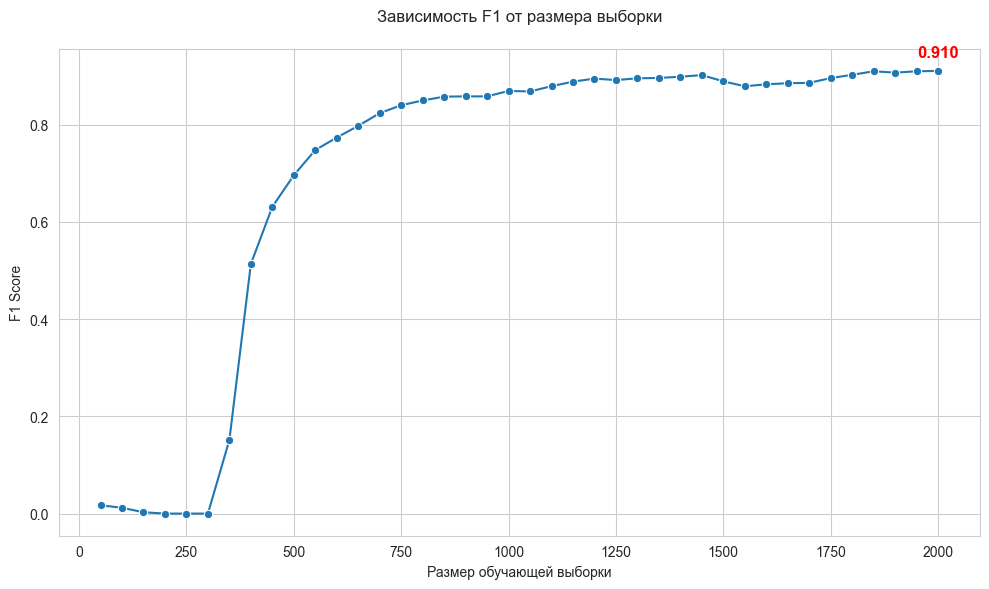


Финальный оставшийся датасет сохранен в remaining_dataset_final.csv
Размер финального датасета: 2043 сообщений


Some weights of BertForTokenClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



NER-модель обучена успешно!

=== Начинаем обучение RE-модели ===

[RE] Этап 1: Подготовка данных
[RE] Используется тренировочный json: PollenNER_TRAIN_2000.json

[RE] Этап 2: Подготовка датасетов

[RE] Статистика распределения классов:
Train (после сэмплирования): Counter({'has_symptom': 1811, 'no_relation': 1468, 'has_medicine': 96})
Test: Counter({'has_symptom': 56, 'no_relation': 41, 'has_medicine': 4})

[RE] Этап 3: Токенизация


Map:   0%|          | 0/3375 [00:00<?, ? examples/s]

Map:   0%|          | 0/101 [00:00<?, ? examples/s]


[RE] Этап 4: Обучение модели


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1
1,No log,0.468768,0.896511
2,0.572000,0.504780,0.878992
3,0.348000,0.454169,0.921702
4,0.261700,0.509117,0.929094
5,0.149100,0.526457,0.929094



RE-модель: Macro F1 = 0.9291
RE-модель сохранена в models/pollen_re_model

[RE] Результаты обучения:
Macro F1 на тесте: 0.9291

[RE] Этап 5: Детальный анализ результатов

[RE] Подробный отчет по целевым классам:
              precision    recall  f1-score   support

 has_symptom     0.8966    0.9286    0.9123        56
has_medicine     1.0000    1.0000    1.0000         4

   micro avg     0.9032    0.9333    0.9180        60
   macro avg     0.9483    0.9643    0.9561        60
weighted avg     0.9034    0.9333    0.9181        60


=== Финальное тестирование на тестовых примерах ===

Тестовый пример 1:
Текст: В Московской области у меня началась аллергия на пыльцу березы, потекли глаза, нос, принимаю Зиртек и Назонекс. У ребенка в Новокузнецке чешутся глаза, уши и течет нос, врач прописал Кромогексал, Назонекс в нос. В Санкт-Петербурге началось цветение ольхи, сильная реакция, принимаю Эриус, но глаза все равно слезятся.

Результаты анализа:
TOPONYM: Московскойобласти, Новокузнецке,

In [17]:
if __name__ == '__main__':
    """
    Основной блок выполнения программы.
    Последовательно запускаем все этапы обработки данных и обучения моделей.
    """
    # ===============================
    # 1. Обучение NER-модели
    # ===============================
    print("\n=== Начинаем обучение NER-модели ===")
    # Запускаем цикл обучения NER с активным обучением
    last_ner_model = run_cycle('dataset_v1.csv', sizes)
    print("\nNER-модель обучена успешно!")

    # ===============================
    # 2. Обучение RE-модели
    # ===============================
    print("\n=== Начинаем обучение RE-модели ===")

    # 2.1. Подготовка данных
    print('\n[RE] Этап 1: Подготовка данных')
    # Ищем последний существующий TRAIN json для обучения
    last_train_json = None
    for size in reversed(sizes):
        candidate = f'PollenNER_TRAIN_{size}.json'
        if os.path.exists(candidate):
            last_train_json = candidate
            break
    if last_train_json is None:
        raise FileNotFoundError('Не найден ни один TRAIN json для RE!')
    print(f'[RE] Используется тренировочный json: {last_train_json}')

    # Парсим разметку из JSON файлов
    train_parsed = parse_labelstudio_json(last_train_json)
    test_parsed = parse_labelstudio_json('PollenNER_TEST.json')

    # 2.2. Подготовка датасетов
    print('\n[RE] Этап 2: Подготовка датасетов')
    # Балансируем классы и применяем oversampling для has_medicine
    re_train, rel_labels = prepare_re_dataset(
        train_parsed,
        relation_labels=RE_RELATION_LABELS,
        max_no_relation_ratio=1,
        oversample_medicine=True
    )
    re_test, _ = prepare_re_dataset(
        test_parsed,
        relation_labels=RE_RELATION_LABELS + ['no_relation'],
        max_no_relation_ratio=1,
        oversample_medicine=False
    )

    # Выводим статистику распределения классов
    print('\n[RE] Статистика распределения классов:')
    print('Train (после сэмплирования):', Counter([ex['relation'] for ex in re_train]))
    print('Test:', Counter([ex['relation'] for ex in re_test]))

    # Создаем словари для преобразования меток
    rel_label2id = {l: i for i, l in enumerate(rel_labels)}
    rel_id2label = {i: l for l, i in rel_label2id.items()}

    # 2.3. Токенизация
    print('\n[RE] Этап 3: Токенизация')
    re_train_ds = prepare_hf_re_dataset(re_train,
                                        TOKENIZER,
                                        rel_label2id)
    re_test_ds = prepare_hf_re_dataset(re_test,
                                       TOKENIZER,
                                       rel_label2id)

    # 2.4. Обучение модели
    print('\n[RE] Этап 4: Обучение модели')
    trainer_re, eval_results_re = train_and_eval_re_model(
        train_ds=re_train_ds,
        test_ds=re_test_ds,
        num_labels=len(rel_labels),
        label2id=rel_label2id,
        id2label=rel_id2label,
        tokenizer=TOKENIZER,
        hf_token=HF_TOKEN,
        output_dir='models/pollen_re_model',
        epochs=5
    )
    print(f"\n[RE] Результаты обучения:")
    print(f"Macro F1 на тесте: {eval_results_re['eval_f1']:.4f}")

    # 2.5. Детальный анализ результатов
    print('\n[RE] Этап 5: Детальный анализ результатов')
    # Получаем предсказания для тестового набора
    re_test_preds = trainer_re.predict(re_test_ds)
    y_true = re_test_preds.label_ids
    y_pred = re_test_preds.predictions.argmax(-1)

    # Преобразуем индексы в метки
    y_true_labels = [rel_id2label[i] for i in y_true]
    y_pred_labels = [rel_id2label[i] for i in y_pred]

    # Выводим подробный отчет по целевым классам
    target_labels = [l for l in rel_labels if l != 'no_relation']
    print("\n[RE] Подробный отчет по целевым классам:")
    print(classification_report(y_true_labels,
                                y_pred_labels,
                                labels=target_labels,
                                digits=4,
                                zero_division=0))


    # ===============================
    # 3. Финальное тестирование
    # ===============================
    print('\n=== Финальное тестирование на тестовых примерах ===')
    for i, text in enumerate(TEST_EXAMPLES, 1):
        print(f'\nТестовый пример {i}:')
        print(f'Текст: {text}')

        # Извлекаем сущности и отношения
        entities, relations = infer_ner_re_on_text(text,
                                                   last_ner_model,
                                                   trainer_re.model,
                                                   TOKENIZER,
                                                   ID2LABEL,
                                                   rel_id2label)

        # Собираем симптомы из отношений has_symptom
        symptoms_from_relations = []
        for rel in relations:
            if rel['relation'] == 'has_symptom':
                head = rel['head']['text']
                tail = rel['tail']['text']
                symptoms_from_relations.append(f'{head} {tail}')

        # Группируем сущности по типу (исключая BODY_PART)
        ent_by_type = {label: [] for label in LABELS if label != 'BODY_PART'}
        for ent in entities:
            if ent['label'] in ent_by_type:
                if ent['label'] != 'SYMPTOM':
                    # Для остальных сущностей используем все найденные
                    ent_by_type[ent['label']].append(ent['text'])

        # Для SYMPTOM записываем данные из has_symptom
        for symptom in symptoms_from_relations:
            ent_by_type['SYMPTOM'].append(symptom)

        # Выводим результаты
        print('\nРезультаты анализа:')
        for label in ent_by_type.keys():
            if ent_by_type[label]:
                ents_str = ', '.join(ent_by_type[label])
                print(f'{label}: {ents_str}')
            else:
                print(f'{label}: не найдено')

## Вывод

Проведённые эксперименты показали, что внедрение отдельного модуля для оценки отношений (RE) существенно повысило точность выделения и классификации симптомов, устранив ложные срабатывания на упоминания частей тела. Уже с 400 размеченными сообщениями наблюдался заметный рост F1‑метрики, а к 2000 примерам модель достигла стабильного уровня в 0.91, демонстрируя зрелость и надёжность алгоритма.

Интеграция NER и RE модулей в единую NLP‑конвейерную архитектуру позволяет в реальном времени автоматически обрабатывать пользовательские сообщения Пыльца Club, извлекая топонимы, симптомы, препараты и аллергены и устанавливая между ними семантические связи.
